# Data Cleaning, Harmonization, and Exploratory Data Analysis

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Import libraries

In [2]:
# standard library
from concurrent import futures
import logging
import multiprocessing as mp
from pathlib import Path
from typing import Callable, Optional, Sequence, Tuple, Iterable, List, Dict, Any

# third-party libraries
import colorcet as cc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import SaltRemover, Descriptors, rdMolDescriptors, rdFingerprintGenerator, DataStructs
from scipy import stats
from tqdm.auto import tqdm

# local libraries
from admet.data.smiles import parallel_canonicalize_smiles
from admet.data.property import compute_molecular_properties
from admet.data.constant import (
    TRANSFORMATIONS,
    COLS_WITH_UNITS,
)
from admet.plot.density import plot_endpoint_distributions, plot_property_distributions
from admet.plot.heatmap import plot_correlation_matrix

In [3]:
%matplotlib inline

In [4]:
# setup tqdm
tqdm.pandas()

In [5]:
# setup logging
level = logging.DEBUG
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    logger.handlers.clear()

formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel(level)

logger.info("Imports successful.")

2025-11-28 10:19:00,298 - __main__ - INFO - Imports successful.


## Load Data

In [6]:
cleaned_data = {}

In [7]:
# project data root directory
base_data_dir = Path().cwd().parents[0] / "assets/dataset/raw"
output_dir = base_data_dir.parents[0] / "eda"
output_dir.mkdir(parents=True, exist_ok=True)

if not base_data_dir.exists():
    raise FileNotFoundError(f"Data directory not found at {base_data_dir}")

logger.info(f"Data directory found at {base_data_dir}")
for dataset_dir in base_data_dir.iterdir():
    logger.info(f"Dataset name: {dataset_dir.name}")

2025-11-28 10:19:00,419 - __main__ - INFO - Data directory found at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/raw
2025-11-28 10:19:00,419 - __main__ - INFO - Dataset name: NCATS
2025-11-28 10:19:00,419 - __main__ - INFO - Dataset name: admetica
2025-11-28 10:19:00,420 - __main__ - INFO - Dataset name: Polaris-Antiviral
2025-11-28 10:19:00,420 - __main__ - INFO - Dataset name: TDC
2025-11-28 10:19:00,420 - __main__ - INFO - Dataset name: Polaris-Biogen
2025-11-28 10:19:00,420 - __main__ - INFO - Dataset name: ExpansionRX
2025-11-28 10:19:00,420 - __main__ - INFO - Dataset name: KERMT
2025-11-28 10:19:00,420 - __main__ - INFO - Dataset name: PharmaBench
2025-11-28 10:19:00,421 - __main__ - INFO - Dataset name: ChEMBL


### Challenge Data: ExpansionRX

In [8]:
# load data
data_path = base_data_dir / "ExpansionRX/full/expansion_data_train.csv"
df_expansionrx = pd.read_csv(data_path)

# rename cols to have units
df_expansionrx.rename(
    columns={k: f"{k} {v}" for k, v in COLS_WITH_UNITS.items() if k in df_expansionrx.columns},
    inplace=True,
)

# drop rows with invalid SMILES
df_expansionrx["SMILES"] = parallel_canonicalize_smiles(
    df_expansionrx["SMILES"].tolist(),
    isomeric=True,
)
n_none_smiles = df_expansionrx["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_expansionrx.dropna(subset=["SMILES"], inplace=True)
    df_expansionrx.reset_index(drop=True, inplace=True)

logger.info(f"Dataframe shape: {df_expansionrx.shape}")
logger.info(f"Dataframe columns: {df_expansionrx.columns.tolist()}")

# log10 transform all targets except LogD
for col in df_expansionrx.columns:
    if col in ["LogD (None)", "SMILES", "Molecule Name (None)"]:
        continue
    else:
        logger.info(f"Log10 transforming column: {col}")
        df_expansionrx[col] = df_expansionrx[col].apply(TRANSFORMATIONS["log10(x)"])
        logger.info(f"Transformed column: {col} with log10")

Canonicalizing SMILES:   0%|          | 0/5326 [00:00<?, ?it/s]

2025-11-28 10:19:02,105 - __main__ - INFO - Dataframe shape: (5326, 11)
2025-11-28 10:19:02,105 - __main__ - INFO - Dataframe columns: ['Molecule Name (None)', 'SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)', 'MPPB (% unbound)', 'MBPB (% unbound)', 'MGMB (% unbound)']
2025-11-28 10:19:02,106 - __main__ - INFO - Log10 transforming column: KSOL (uM)
2025-11-28 10:19:02,110 - __main__ - INFO - Transformed column: KSOL (uM) with log10
2025-11-28 10:19:02,110 - __main__ - INFO - Log10 transforming column: HLM CLint (mL/min/kg)
2025-11-28 10:19:02,114 - __main__ - INFO - Transformed column: HLM CLint (mL/min/kg) with log10
2025-11-28 10:19:02,114 - __main__ - INFO - Log10 transforming column: MLM CLint (mL/min/kg)
2025-11-28 10:19:02,118 - __main__ - INFO - Transformed column: MLM CLint (mL/min/kg) with log10
2025-11-28 10:19:02,119 - __main__ - INFO - Log10 transforming c

In [9]:
df_expansionrx.sort_values("Molecule Name (None)", inplace=True)
df_expansionrx.reset_index(drop=True, inplace=True)

df_expansionrx

Molecule Name (None)                                             SMILES  \
0               E-0001321  CN1CCC[C@H]1COc1ccc(-c2nc3cc(-c4ccc5[nH]c(-c6c...   
1               E-0001780                  COc1ccc2c(c1)c1cc3cnccc3c(C)c1n2C   
2               E-0001827     Cc1c2ccncc2cc2c3cc(OCCCN4CCN(C)CC4)ccc3n(C)c12   
3               E-0002019  CN(C)CCCOc1ccc(-c2nc3cc(NC(=O)c4ccc5[nH]c(-c6c...   
4               E-0002036  CN(C)CCCOc1ccc2nc(-c3ccc(-c4nc5ccc(OCCCN(C)C)c...   
...                   ...                                                ...   
5321            E-0020096  CCn1c(C(=O)N2CCN(c3ccncc3)CC2)cc2cc(-c3nnc(C4C...   
5322            E-0020097  Cc1nnc(-c2cnc3c(c2)cc(C(=O)N2CCCN(c4ccncc4C)CC...   
5323            E-0020098  Cc1nnc(-c2ccc3c(c2)cc(C(=O)N2CCCN(c4ccncc4)CC2...   
5324            E-0020099  Cc1nnc(-c2ccc3c(c2)cc(C(=O)N2CCCN(c4ccncc4C)CC...   
5325            E-0020100  Cc1nnc(-c2cnn3cc(C(=O)N4CCN(c5ccncc5)CC4)cc3c2)s1   

      LogD (None)  KSOL (uM)  HLM CLint (mL/min/kg)  MLM CLint (mL/min/kg)  \
0             NaN        NaN               1.751279               2.260787   
1             NaN        NaN               2.205204               3.130687   
2             NaN        NaN                    NaN               2.286681   
3             NaN        NaN               0.977724                    NaN   
4             NaN        NaN                    NaN               2.209515   
...           ...        ...                    ...                    ...   
5321          2.5   2.409933                    NaN                    NaN   
5322          1.5   2.442480                    NaN                    NaN   
5323          1.0   2.436163                    NaN                    NaN   
5324          2.2   2.436163                    NaN                    NaN   
5325          0.5   2.155336                    NaN                    NaN   

      Caco-2 Permeability Papp A>B (10^-6 cm/s)  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   
...                                         ...   
5321                                        NaN   
5322                                        NaN   
5323                                        NaN   
5324                                        NaN   
5325                                        NaN   

      Caco-2 Permeability Efflux (None)  MPPB (% unbound)  MBPB (% unbound)  \
0                                   NaN               NaN               NaN   
1                                   NaN               NaN               NaN   
2                                   NaN               NaN               NaN   
3                                   NaN               NaN               NaN   
4                                   NaN               NaN               NaN   
...                                 ...               ...               ...   
5321                                NaN               NaN               NaN   
5322                                NaN               NaN               NaN   
5323                                NaN               NaN               NaN   
5324                                NaN               NaN               NaN   
5325                                NaN               NaN               NaN   

      MGMB (% unbound)  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4            -1.913605  
...                ...  
5321               NaN  
5322               NaN  
5323               NaN  
5324               NaN  
5325               NaN  

[5326 rows x 11 columns]

In [10]:
missing_val = df_expansionrx.iloc[0]["LogD (None)"]

2025-11-28 10:19:02,335 - __main__ - INFO - Column: HLM CLint (mL/min/kg) | Total values: 5326 | Negative values: 164 | Fraction negative: 0.0308 | Distinct values: 1
2025-11-28 10:19:02,387 - __main__ - INFO - Column: MLM CLint (mL/min/kg) | Total values: 5326 | Negative values: 147 | Fraction negative: 0.0276 | Distinct values: 1
2025-11-28 10:19:02,405 - __main__ - INFO - Column: MPPB (% unbound) | Total values: 5326 | Negative values: 10 | Fraction negative: 0.0019 | Distinct values: 1
2025-11-28 10:19:02,421 - __main__ - INFO - Column: MBPB (% unbound) | Total values: 5326 | Negative values: 2 | Fraction negative: 0.0004 | Distinct values: 1
2025-11-28 10:19:02,437 - __main__ - INFO - Column: MGMB (% unbound) | Total values: 5326 | Negative values: 1 | Fraction negative: 0.0002 | Distinct values: 1
2025-11-28 10:19:02,453 - __main__ - WARNING - Column Molecule Name (None) not in cutoff columns, skipping.
2025-11-28 10:19:02,453 - __main__ - WARNING - Column SMILES not in cutoff co

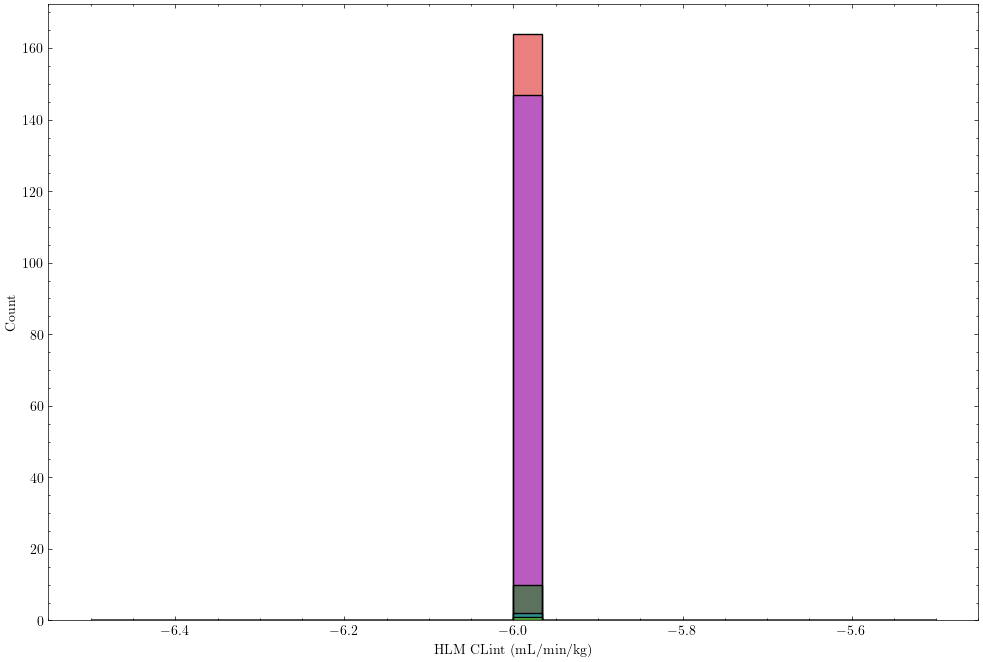

In [11]:
# For {MPPB, MBPB, MGMB} compute number of values < 0, their fraction, and distint values
BINDING_CUTOFF = -3.0
cutoff_columns = ["MPPB", "MBPB", "MGMB", "HLM CLint", "MLM CLint"]
df_expansionrx_filtered = df_expansionrx.copy()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

for col in df_expansionrx.columns:
    if any(x in col for x in cutoff_columns):
        n_values = df_expansionrx.shape[0]
        sub_series = df_expansionrx[col].dropna()
        sub_series = sub_series[sub_series < BINDING_CUTOFF]

        n_negative = sub_series.shape[0]
        fraction_negative = n_negative / n_values if n_values > 0 else 0.0
        n_distinct = sub_series.nunique()
        logger.info(
            f"Column: {col} | Total values: {n_values} | Negative values: {n_negative} | "
            f"Fraction negative: {fraction_negative:.4f} | Distinct values: {n_distinct}"
        )

        sns.histplot(sub_series, bins=30, kde=True, ax=ax, label=col, alpha=0.5)

# REVIEW: replace with np.nan
for col in df_expansionrx.columns:
    if any(x in col for x in cutoff_columns):
        sub_series = df_expansionrx[col].dropna()
        idx_to_drop = sub_series[sub_series < BINDING_CUTOFF].index.tolist()
        if len(idx_to_drop) > 0:
            logger.info(f"Setting {len(idx_to_drop)} values in column {col} below cutoff to NaN")
            percentage_to_nan = len(idx_to_drop) / sub_series.shape[0] * 100
            logger.debug(f"Percentage of data in column {col} being set to NaN: {percentage_to_nan:.4f}%")
        df_expansionrx_filtered.loc[idx_to_drop, col] = missing_val
    else:
        logger.warning(f"Column {col} not in cutoff columns, skipping.")

In [12]:
cleaned_data["expansionrx"] = df_expansionrx_filtered.copy()

df = df_expansionrx_filtered.copy()
df_props = compute_molecular_properties(df["SMILES"])
logger.info(f"Molecular properties computed for {df_props.shape[0]} molecules and {df_props.shape[1]} properties.")
logger.debug(f"Molecular properties: {df_props.columns.tolist()}")

Computing molecular properties:   0%|          | 0/5326 [00:00<?, ?molecule/s]

2025-11-28 10:19:04,962 - __main__ - INFO - Molecular properties computed for 5326 molecules and 9 properties.
2025-11-28 10:19:04,962 - __main__ - DEBUG - Molecular properties: ['SMILES', 'MW', 'TPSA', 'HBA', 'HBD', 'RotBonds', 'LogP', 'NumHeavyAtoms', 'NumRings']


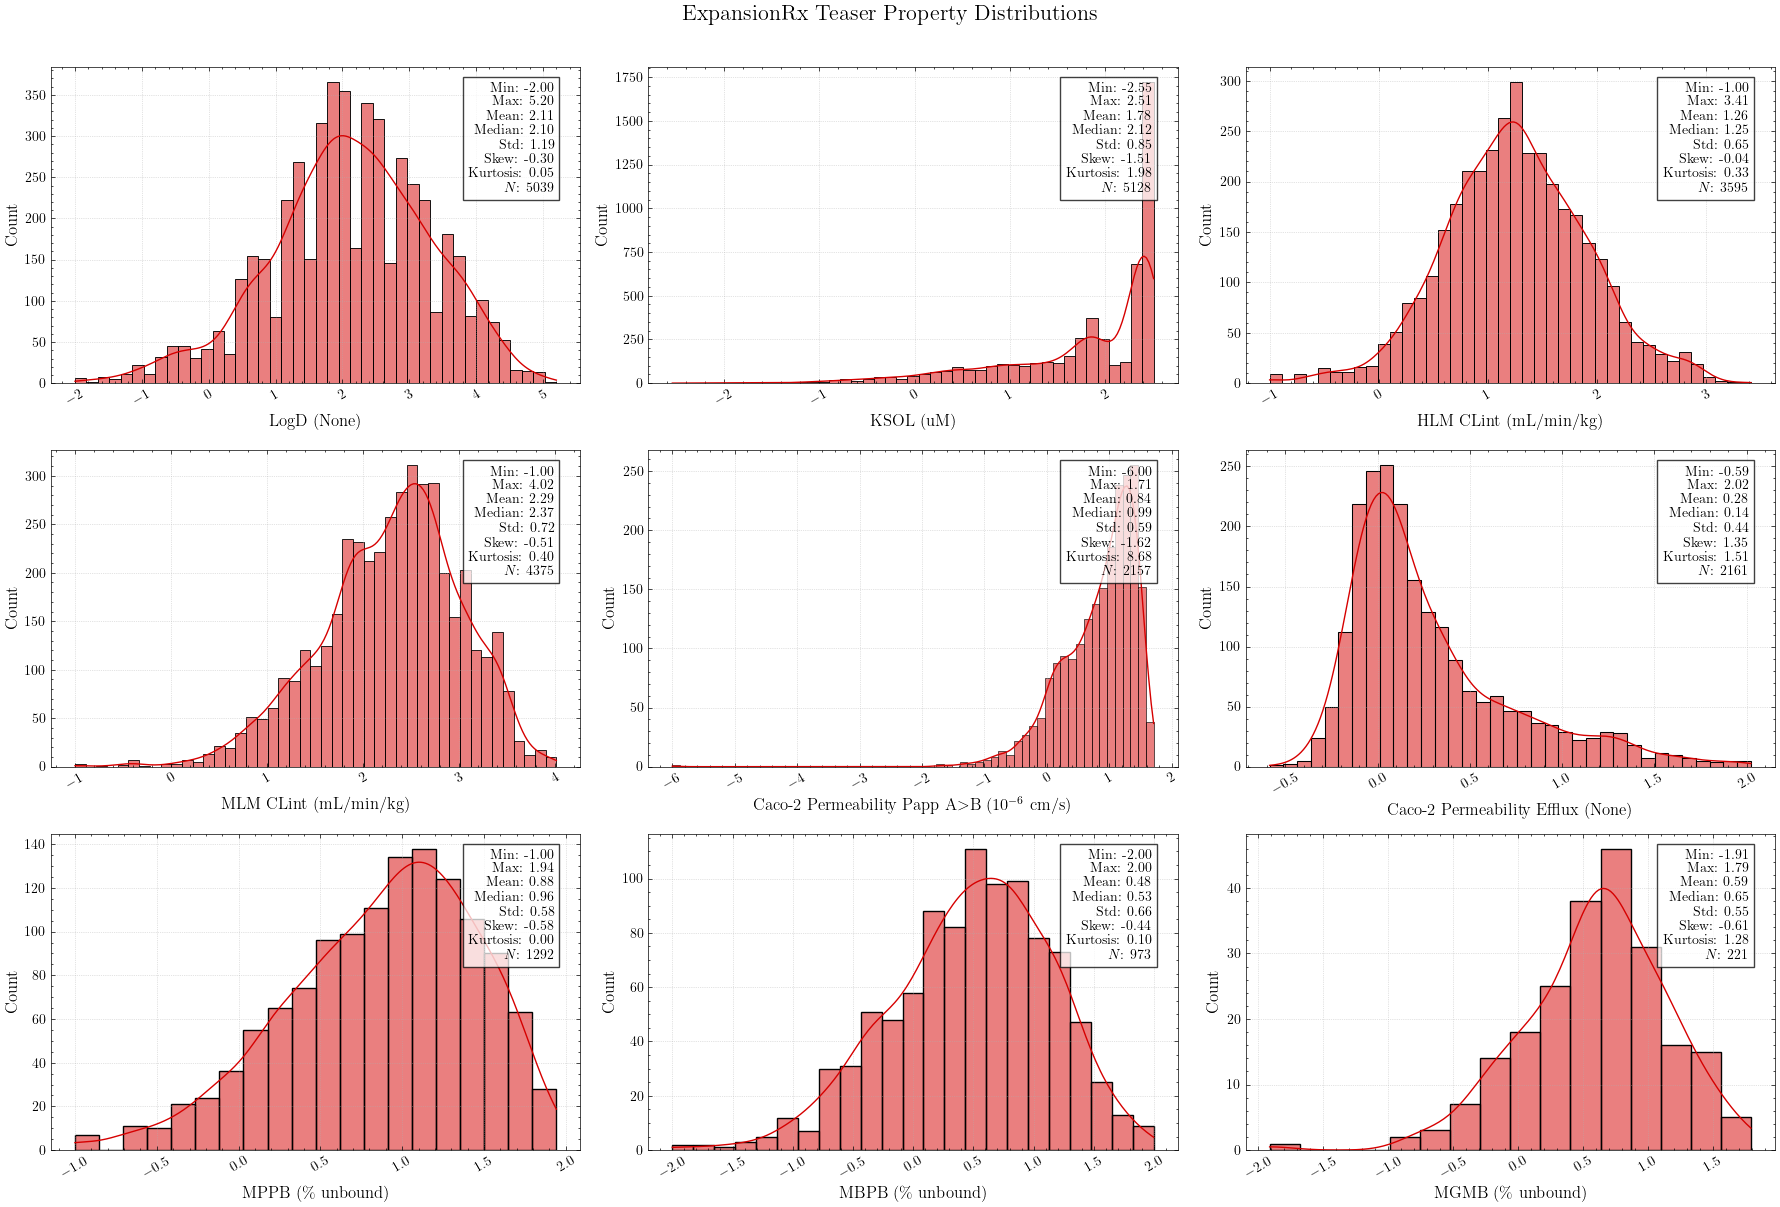

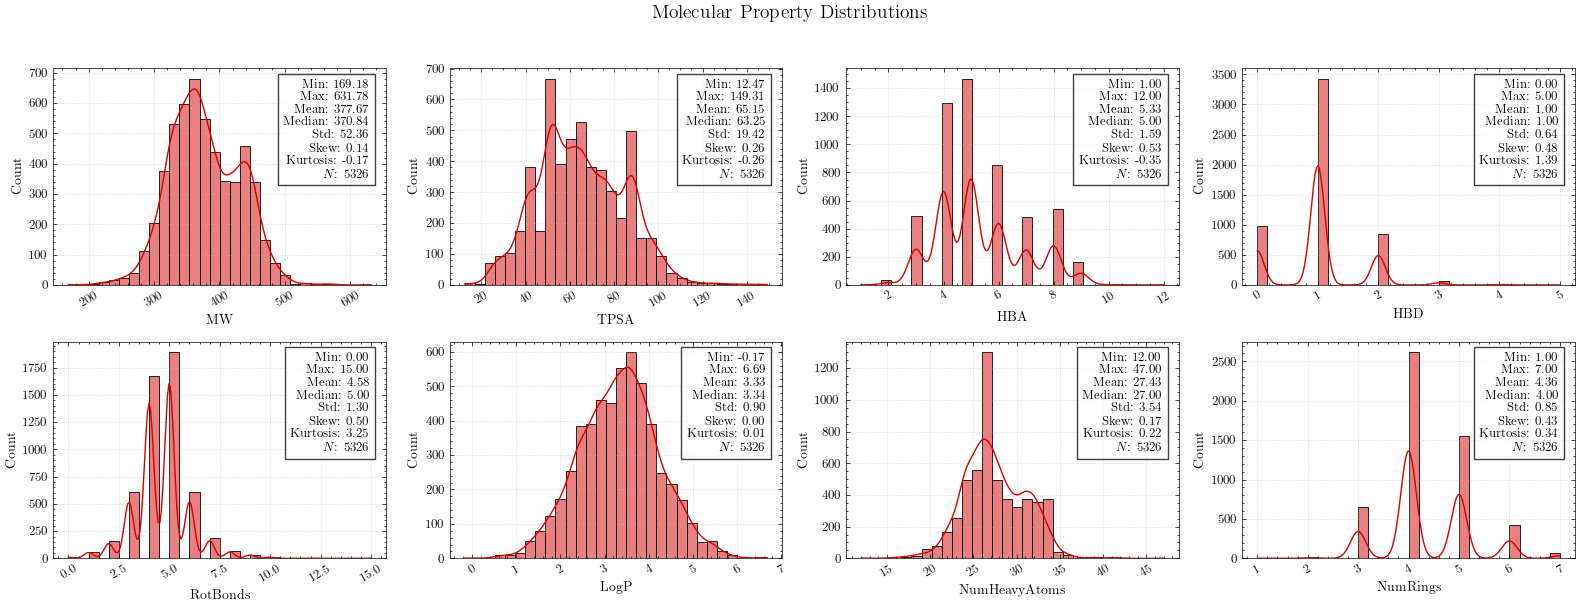

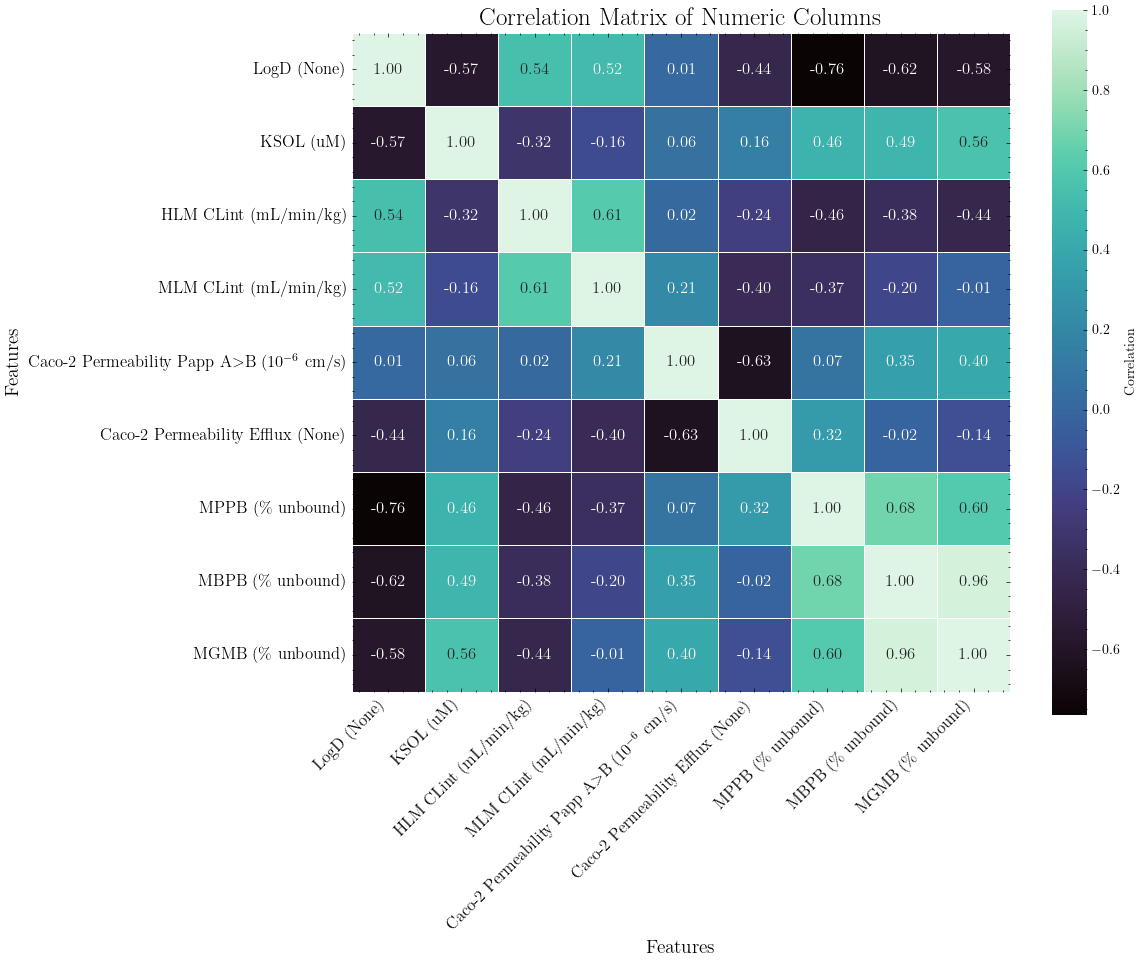

In [13]:
fname = "expansionrx"
output_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plot_endpoint_distributions(
    df,
    n_cols=3,
    title="ExpansionRx Teaser Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

### KERMT Dataset

#### Public

Key dataset information

In [14]:
files_biogen = [
    "KERMT/export_public_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

# map from KERMT data to ExpansionRX data on SMILES
map_cols_kermt_to_expansionrx = [
    {
        "input_col": "LogD_pH_7.4",  # NOTE: pH 7.4
        "output_col": "LogD (None)",
        "transform": TRANSFORMATIONS["None"],
    },
    {
        "input_col": "kinetic_logSaq",  # log(M)
        "output_col": "KSOL (uM)",
        "transform": TRANSFORMATIONS["10^(x+6)"],
    },
    {
        "input_col": "CL_microsome_human",  # log(mL/min/kg)
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": TRANSFORMATIONS["10^(x); 1/kg to 1/g"],
    },
    {
        "input_col": "CL_microsome_mouse",  # log(mL/min/kg)
        "output_col": "MLM CLint (mL/min/kg)",
        "transform": TRANSFORMATIONS["10^(x); 1/kg to 1/g"],
    },
    {
        "input_col": "Papp_Caco2",  # log(10^-6 cm/sec)
        "output_col": "Caco-2 Permeability Papp A>B (10^-6 cm/s)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
    {
        "input_col": "Rat_fraction_unbound_plasma",  # log(% Unbound)
        "output_col": "MPPB (% unbound)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
    {
        # REVIEW: low confidence mapping
        "input_col": "Pgp_human",  # log(None)
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
]

Load and concatenate public KERMT files. Drop duplicates and bad data.

In [15]:
df_kermt_public = pd.DataFrame()
for f in files_biogen:
    df = pd.read_csv(base_data_dir / f)
    df["file"] = f
    df_kermt_public = pd.concat([df_kermt_public, df], ignore_index=True)

# rename smiles --> SMILES
df_kermt_public.rename(columns={"smiles": "SMILES"}, inplace=True)

# drop rows with invalid SMILES
df_kermt_public["SMILES"] = parallel_canonicalize_smiles(
    df_kermt_public["SMILES"].tolist(),
    isomeric=True,
)
n_none_smiles = df_kermt_public["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_kermt_public.dropna(subset=["SMILES"], inplace=True)
    df_kermt_public.reset_index(drop=True, inplace=True)

logger.info(f"KERMT Public Dataframe shape: {df_kermt_public.shape}")
logger.info(f"KERMT Public Dataframe columns: {df_kermt_public.columns.tolist()}")

# print finite number of entries for each column
for col in df_kermt_public.columns:
    if not pd.api.types.is_numeric_dtype(df_kermt_public[col]):
        continue
    n_finite = np.isfinite(df_kermt_public[col]).sum()
    logger.info(f"Column '{col}' has {n_finite} finite entries out of {len(df_kermt_public)}")

Canonicalizing SMILES:   0%|          | 0/114112 [00:00<?, ?it/s]

2025-11-28 10:19:43,186 - __main__ - INFO - KERMT Public Dataframe shape: (114112, 27)
2025-11-28 10:19:43,187 - __main__ - INFO - KERMT Public Dataframe columns: ['SMILES', 'CL_microsome_human', 'CL_microsome_mouse', 'CL_microsome_rat', 'CL_total_dog', 'CL_total_human', 'CL_total_monkey', 'CL_total_rat', 'CYP2C8_inhibition', 'CYP2C9_inhibition', 'CYP2D6_inhibition', 'CYP3A4_inhibition', 'Dog_fraction_unbound_plasma', 'Human_fraction_unbound_plasma', 'Monkey_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'Papp_Caco2', 'Pgp_human', 'hERG_binding', 'LogD_pH_7.4', 'kinetic_logSaq', 'thermo_logSaq', 'VDss_dog', 'VDss_human', 'VDss_monkey', 'VDss_rat', 'file']
2025-11-28 10:19:43,187 - __main__ - INFO - Column 'CL_microsome_human' has 5218 finite entries out of 114112
2025-11-28 10:19:43,188 - __main__ - INFO - Column 'CL_microsome_mouse' has 663 finite entries out of 114112
2025-11-28 10:19:43,188 - __main__ - INFO - Column 'CL_microsome_rat' has 1798 finite entries out of 114112

Transform dataset column names to be compatible with ExpansionRX dataset.

In [16]:
df_kermt_public_admet_cleaned = df_kermt_public[["SMILES"]]
for mapping in map_cols_kermt_to_expansionrx:
    input_col = mapping["input_col"]
    output_col = mapping["output_col"]
    transform = mapping["transform"]

    df_input = df_kermt_public[["SMILES", input_col]].copy()
    df_input[output_col] = df_input[input_col].apply(transform).copy()
    df_input.drop(columns=[input_col], inplace=True)

    df_kermt_public_admet_cleaned = pd.merge(df_kermt_public_admet_cleaned, df_input, on="SMILES")

# log10 transform all targets except LogD
for col in df_kermt_public_admet_cleaned.columns:
    if col in ["LogD (None)", "SMILES"]:
        continue
    else:
        logger.info(f"Log10 transforming column: {col}")
        df_kermt_public_admet_cleaned[col] = df_kermt_public_admet_cleaned[col].apply(TRANSFORMATIONS["log10(x)"])
        logger.info(f"Transformed column: {col} with log10")

2025-11-28 10:19:44,018 - __main__ - INFO - Log10 transforming column: KSOL (uM)
2025-11-28 10:19:44,102 - __main__ - INFO - Transformed column: KSOL (uM) with log10
2025-11-28 10:19:44,103 - __main__ - INFO - Log10 transforming column: HLM CLint (mL/min/kg)
2025-11-28 10:19:44,185 - __main__ - INFO - Transformed column: HLM CLint (mL/min/kg) with log10
2025-11-28 10:19:44,185 - __main__ - INFO - Log10 transforming column: MLM CLint (mL/min/kg)
2025-11-28 10:19:44,267 - __main__ - INFO - Transformed column: MLM CLint (mL/min/kg) with log10
2025-11-28 10:19:44,268 - __main__ - INFO - Log10 transforming column: Caco-2 Permeability Papp A>B (10^-6 cm/s)
2025-11-28 10:19:44,350 - __main__ - INFO - Transformed column: Caco-2 Permeability Papp A>B (10^-6 cm/s) with log10
2025-11-28 10:19:44,351 - __main__ - INFO - Log10 transforming column: MPPB (% unbound)
2025-11-28 10:19:44,433 - __main__ - INFO - Transformed column: MPPB (% unbound) with log10
2025-11-28 10:19:44,433 - __main__ - INFO - 

In [17]:
# check for repeated SMILES
n_total = len(df_kermt_public_admet_cleaned)
n_unique = df_kermt_public_admet_cleaned["SMILES"].nunique()
n_duplicates = n_total - n_unique
if n_duplicates > 0:
    logger.warning(f"Found {n_duplicates} duplicate SMILES in merged KERMT-ExpansionRX dataframe")
    # average (skip NaNs) over duplicates
    df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned.groupby("SMILES", as_index=False).mean()
    logger.info(f"Dataframe shape after averaging duplicates: {df_kermt_public_admet_cleaned.shape}")

# check for overlap with ExpansionRx teaser dataset
smiles_teaser = set(df_expansionrx["SMILES"].tolist())
smiles_kermt_expansionrx = set(df_kermt_public_admet_cleaned["SMILES"].tolist())
overlap_smiles = smiles_teaser.intersection(smiles_kermt_expansionrx)
n_overlap = len(overlap_smiles)
if n_overlap > 0:
    logger.warning(f"Found {n_overlap} overlapping SMILES between ExpansionRx teaser and KERMT-ExpansionRX datasets")

2025-11-28 10:19:44,589 - __main__ - WARNING - Found 11985 duplicate SMILES in merged KERMT-ExpansionRX dataframe
2025-11-28 10:19:44,677 - __main__ - INFO - Dataframe shape after averaging duplicates: (114065, 8)
2025-11-28 10:19:44,684 - __main__ - WARNING - Found 2 overlapping SMILES between ExpansionRx teaser and KERMT-ExpansionRX datasets


In [18]:
# print num non-nan entries for each column
for col in df_kermt_public_admet_cleaned.columns:
    if col == "SMILES":
        continue
    n_non_nan = df_kermt_public_admet_cleaned[col].notna().sum()
    logger.info(f"Column '{col}' has {n_non_nan} non-NaN entries out of {len(df_kermt_public_admet_cleaned)}")

2025-11-28 10:19:44,764 - __main__ - INFO - Column 'LogD (None)' has 4190 non-NaN entries out of 114065
2025-11-28 10:19:44,765 - __main__ - INFO - Column 'KSOL (uM)' has 74895 non-NaN entries out of 114065
2025-11-28 10:19:44,765 - __main__ - INFO - Column 'HLM CLint (mL/min/kg)' has 5218 non-NaN entries out of 114065
2025-11-28 10:19:44,766 - __main__ - INFO - Column 'MLM CLint (mL/min/kg)' has 663 non-NaN entries out of 114065
2025-11-28 10:19:44,766 - __main__ - INFO - Column 'Caco-2 Permeability Papp A>B (10^-6 cm/s)' has 6457 non-NaN entries out of 114065
2025-11-28 10:19:44,767 - __main__ - INFO - Column 'MPPB (% unbound)' has 237 non-NaN entries out of 114065
2025-11-28 10:19:44,767 - __main__ - INFO - Column 'Caco-2 Permeability Efflux (None)' has 2073 non-NaN entries out of 114065


In [19]:
cleaned_data["kermt_public"] = df_kermt_public_admet_cleaned.copy()

Visualize distributions of dataset

Computing molecular properties:   0%|          | 0/114065 [00:00<?, ?molecule/s]

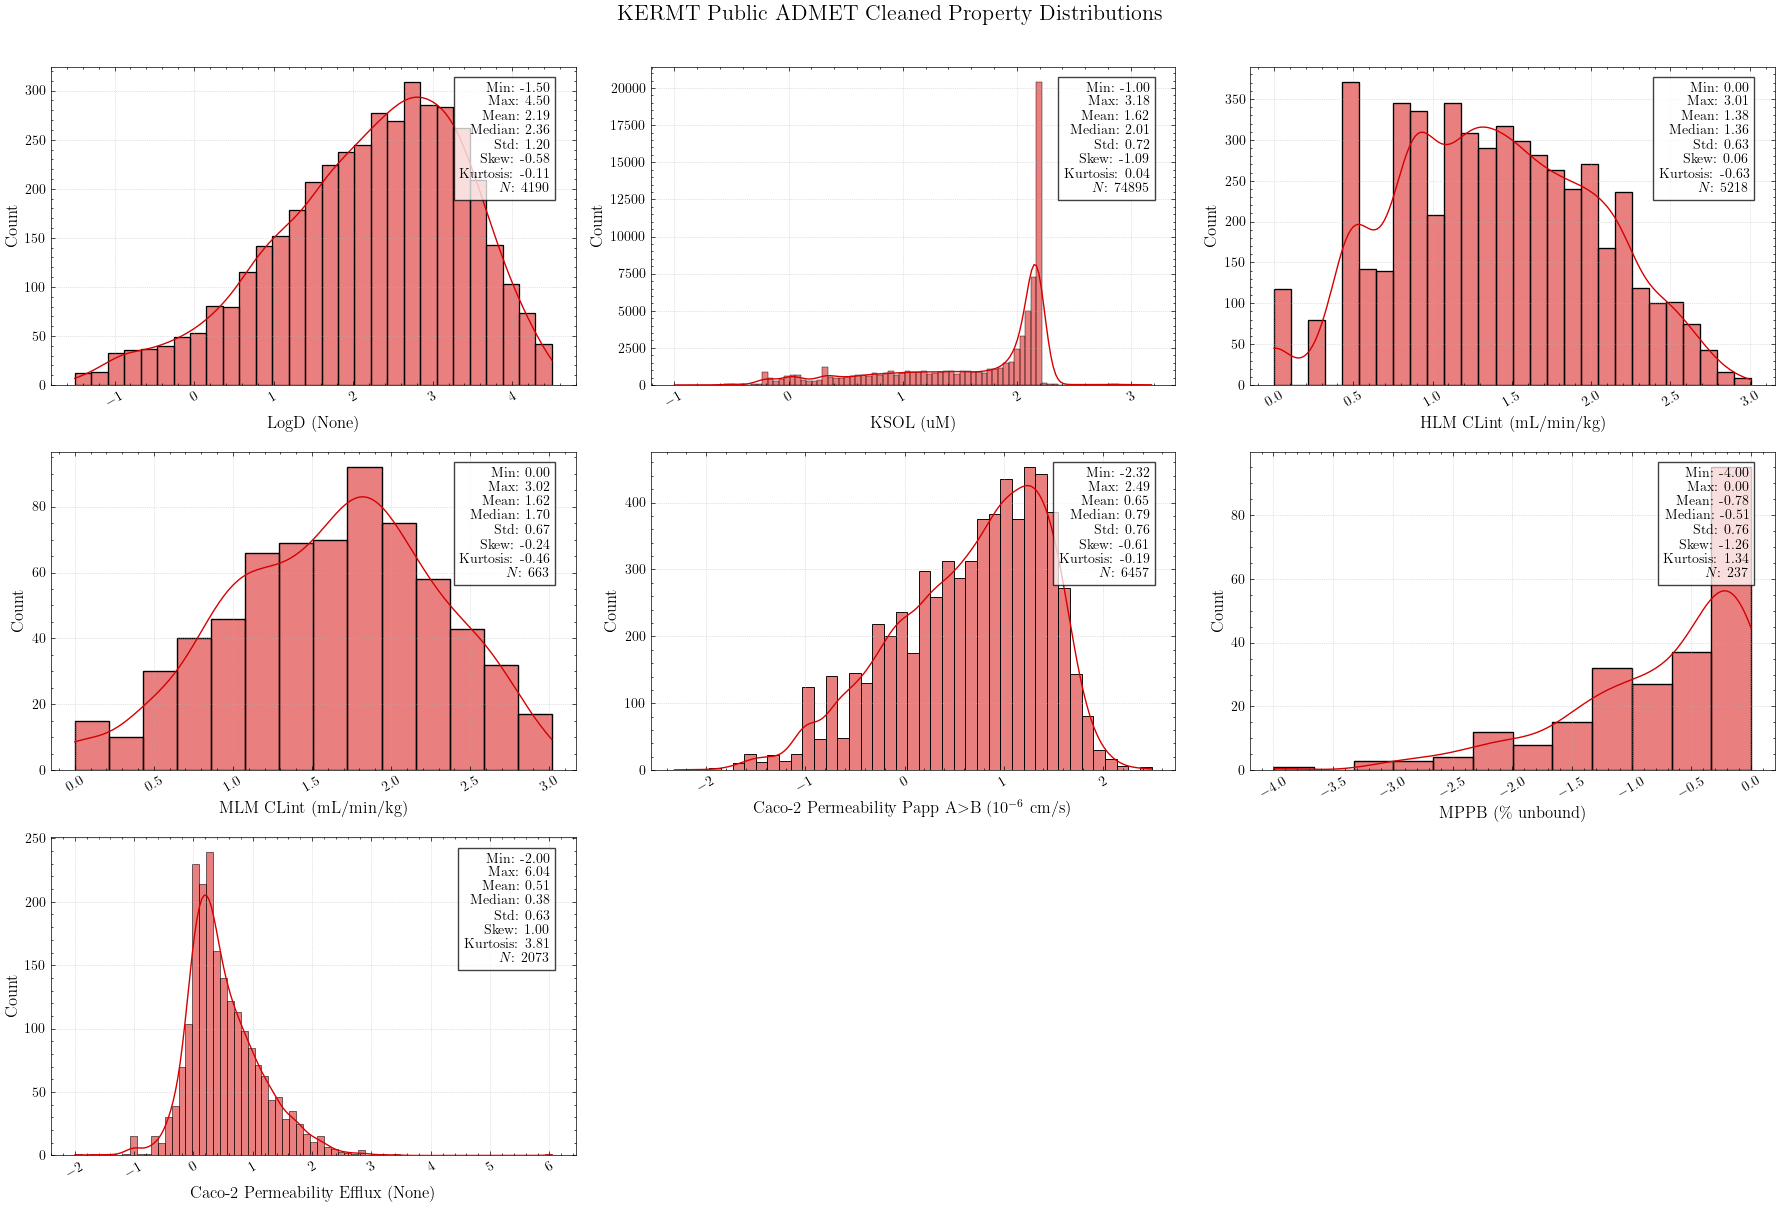

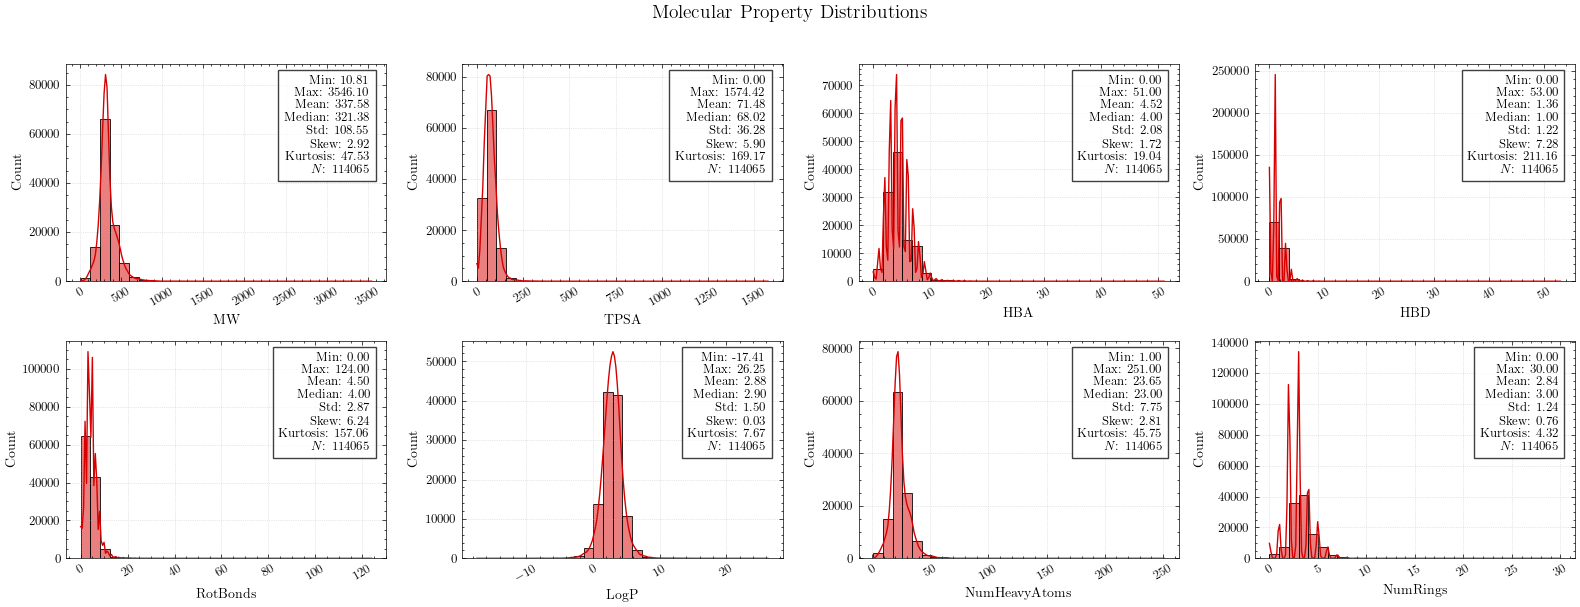

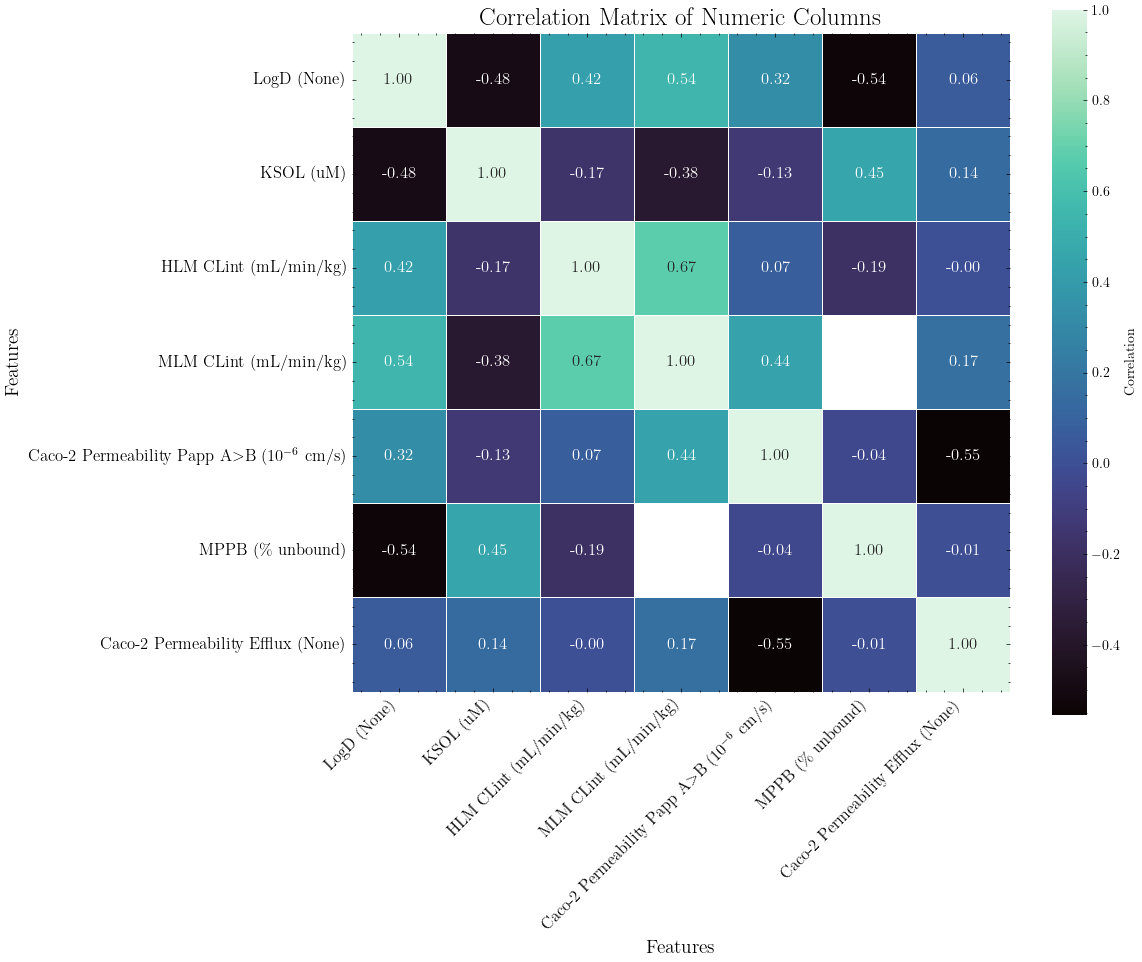

In [20]:
df = df_kermt_public_admet_cleaned.copy()
fname = "kermt_public_admet_cleaned"

df_props = compute_molecular_properties(df["SMILES"])
output_dir.mkdir(parents=True, exist_ok=True)
fig, ax = plot_endpoint_distributions(
    df,
    n_cols=3,
    title="KERMT Public ADMET Cleaned Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

#### Biogen

In [21]:
files_biogen = [
    "KERMT/export_biogen_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

map_cols_biogen_to_expansionrx = [
    {
        "input_col": "SOLY_6.8",  # NOTE: This is not pH 7
        "output_col": "KSOL (uM)",
        "transform": TRANSFORMATIONS["ug/mL to uM"],
    },
    {
        "input_col": "MDR1-MDCK_ER",  # NOTE: MDCK not Caco-2
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": TRANSFORMATIONS["None"],
    },
    {
        "input_col": "HLM_CLint",
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
    {
        "input_col": "Rat_fraction_unbound_plasma",  # log(% Unbound)
        "output_col": "MPPB (% unbound)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
]

In [22]:
# load and concatenate biogen files
df_kermt_biogen = [pd.read_csv(base_data_dir / file) for file in files_biogen]
df_kermt_biogen = pd.concat(df_kermt_biogen, ignore_index=True)
logger.info(f"KERMT Biogen Dataframe shape: {df_kermt_biogen.shape}")
logger.info(f"KERMT Biogen Dataframe columns: {df_kermt_biogen.columns.tolist()}")

# rename smiles --> SMILES
df_kermt_biogen.rename(columns={"smiles": "SMILES"}, inplace=True)

# drop rows with invalid SMILES
df_kermt_biogen["SMILES"] = parallel_canonicalize_smiles(
    df_kermt_biogen["SMILES"].tolist(),
    isomeric=True,
)
df_kermt_biogen["MW"] = df_kermt_biogen["SMILES"].apply(
    lambda smi: Descriptors.MolWt(Chem.MolFromSmiles(smi)) if smi is not None else np.nan
)

n_none_smiles = df_kermt_biogen["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_kermt_biogen.dropna(subset=["SMILES"], inplace=True)
    df_kermt_biogen.reset_index(drop=True, inplace=True)
logger.info(f"KERMT Biogen Dataframe shape after cleaning: {df_kermt_biogen.shape}")

2025-11-28 10:20:35,225 - __main__ - INFO - KERMT Biogen Dataframe shape: (3521, 7)
2025-11-28 10:20:35,226 - __main__ - INFO - KERMT Biogen Dataframe columns: ['smiles', 'HLM_CLint', 'MDR1-MDCK_ER', 'SOLY_6.8', 'Human_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'RLM_Clint']


Canonicalizing SMILES:   0%|          | 0/3521 [00:00<?, ?it/s]

2025-11-28 10:20:36,465 - __main__ - INFO - KERMT Biogen Dataframe shape after cleaning: (3521, 8)


In [23]:
# map to ExpansionRX columns
df_kermt_biogen_admet_cleaned = df_kermt_biogen[["SMILES"]]
for mapping in map_cols_biogen_to_expansionrx:
    input_col = mapping["input_col"]
    output_col = mapping["output_col"]
    transform = mapping["transform"]

    df_input = df_kermt_biogen[["SMILES", input_col]].copy()
    if input_col == "SOLY_6.8":
        # need MW for conversion
        df_input = pd.merge(
            df_input,
            df_kermt_biogen[["SMILES", "MW"]],
            on="SMILES",
            how="left",
        )
        df_input[output_col] = df_input.apply(
            lambda row: transform(row[input_col], row["MW"]),
            axis=1,
        )
        df_input.drop(columns=["MW"], inplace=True)
    else:
        df_input[output_col] = df_input[input_col].apply(transform).copy()

    logger.info(f"Transformed column '{input_col}' to '{output_col}' with {len(df_input)} entries.")
    df_input.drop(columns=[input_col], inplace=True)

    df_kermt_biogen_admet_cleaned = pd.merge(df_kermt_biogen_admet_cleaned, df_input, on="SMILES")

2025-11-28 10:20:36,817 - __main__ - INFO - Transformed column 'SOLY_6.8' to 'KSOL (uM)' with 3521 entries.
2025-11-28 10:20:36,820 - __main__ - INFO - Transformed column 'MDR1-MDCK_ER' to 'Caco-2 Permeability Efflux (None)' with 3521 entries.
2025-11-28 10:20:36,825 - __main__ - INFO - Transformed column 'HLM_CLint' to 'HLM CLint (mL/min/kg)' with 3521 entries.
2025-11-28 10:20:36,830 - __main__ - INFO - Transformed column 'Rat_fraction_unbound_plasma' to 'MPPB (% unbound)' with 3521 entries.


In [24]:
# print num non-nan entries for each column
for col in df_kermt_biogen_admet_cleaned.columns:
    if col == "SMILES":
        continue
    n_non_nan = df_kermt_biogen_admet_cleaned[col].notna().sum()
    logger.info(f"Column '{col}' has {n_non_nan} non-NaN entries out of {len(df_kermt_biogen_admet_cleaned)}")

2025-11-28 10:20:36,893 - __main__ - INFO - Column 'KSOL (uM)' has 2173 non-NaN entries out of 3521
2025-11-28 10:20:36,894 - __main__ - INFO - Column 'Caco-2 Permeability Efflux (None)' has 2642 non-NaN entries out of 3521
2025-11-28 10:20:36,894 - __main__ - INFO - Column 'HLM CLint (mL/min/kg)' has 3087 non-NaN entries out of 3521
2025-11-28 10:20:36,894 - __main__ - INFO - Column 'MPPB (% unbound)' has 168 non-NaN entries out of 3521


In [25]:
# log10 transform all targets except LogD
for col in df_kermt_biogen_admet_cleaned.columns:
    if col in ["LogD (None)", "SMILES"]:
        continue
    else:
        logger.info(f"Log10 transforming column: {col}")
        df_kermt_biogen_admet_cleaned[col] = df_kermt_biogen_admet_cleaned[col].apply(TRANSFORMATIONS["log10(x)"])
        logger.info(f"Transformed column: {col} with log10")

2025-11-28 10:20:37,386 - __main__ - INFO - Log10 transforming column: KSOL (uM)
2025-11-28 10:20:37,389 - __main__ - INFO - Transformed column: KSOL (uM) with log10
2025-11-28 10:20:37,390 - __main__ - INFO - Log10 transforming column: Caco-2 Permeability Efflux (None)
2025-11-28 10:20:37,393 - __main__ - INFO - Transformed column: Caco-2 Permeability Efflux (None) with log10
2025-11-28 10:20:37,393 - __main__ - INFO - Log10 transforming column: HLM CLint (mL/min/kg)
2025-11-28 10:20:37,396 - __main__ - INFO - Transformed column: HLM CLint (mL/min/kg) with log10
2025-11-28 10:20:37,396 - __main__ - INFO - Log10 transforming column: MPPB (% unbound)
2025-11-28 10:20:37,399 - __main__ - INFO - Transformed column: MPPB (% unbound) with log10


In [26]:
# export data
logger.info(f"KERMT Biogen-ExpansionRX Dataframe shape: {df_kermt_biogen_admet_cleaned.shape}")
cleaned_data["kermt_biogen"] = df_kermt_biogen_admet_cleaned.copy()

2025-11-28 10:20:37,887 - __main__ - INFO - KERMT Biogen-ExpansionRX Dataframe shape: (3521, 5)


Computing molecular properties:   0%|          | 0/3521 [00:00<?, ?molecule/s]

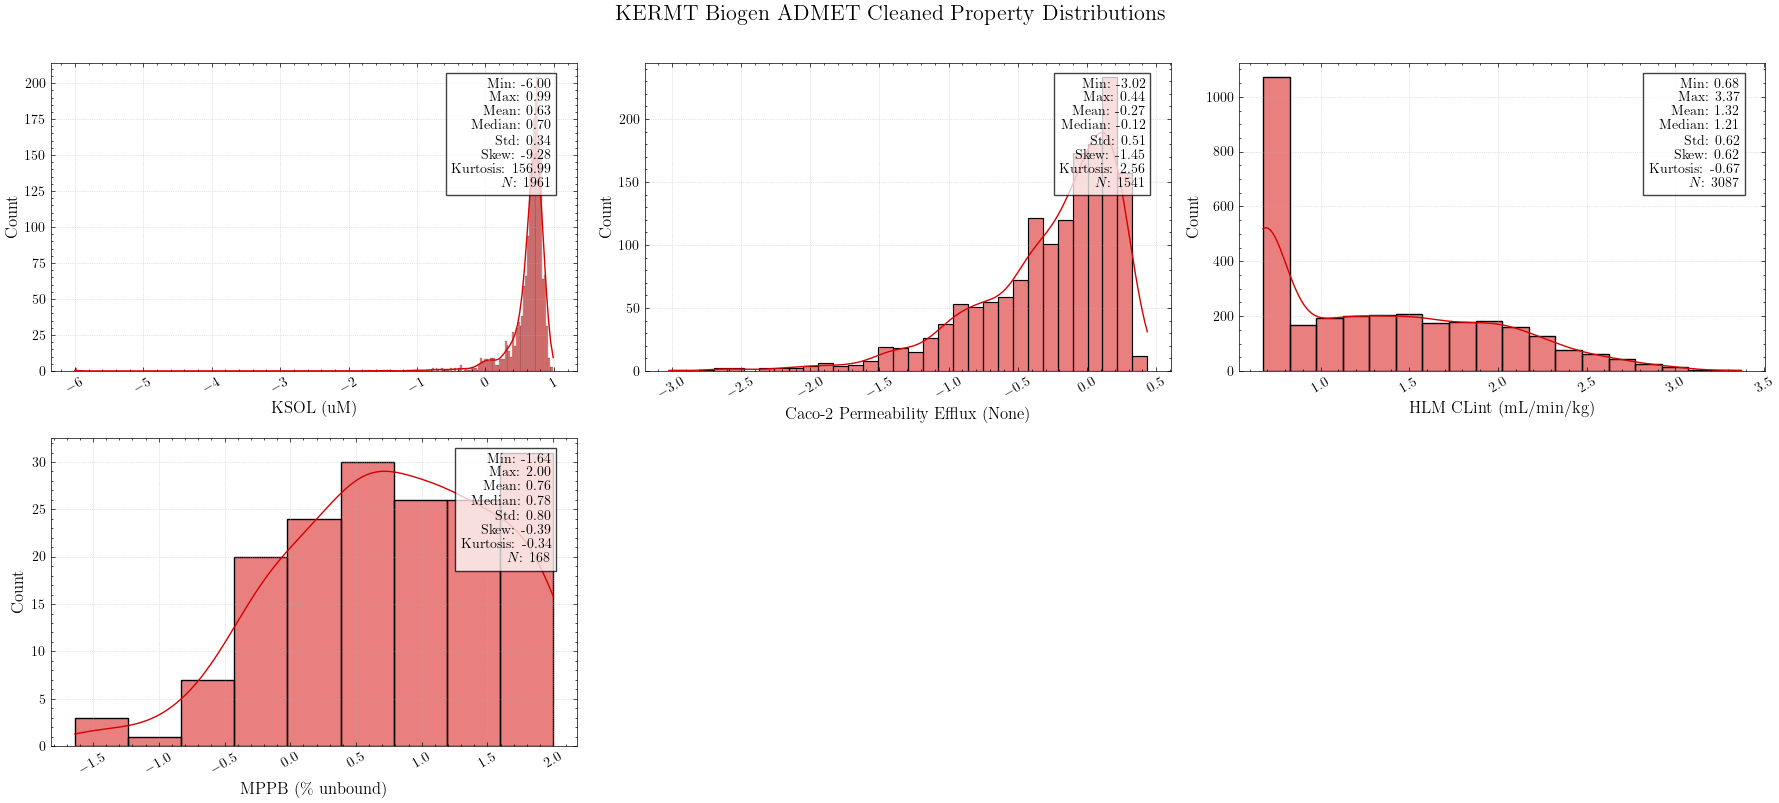

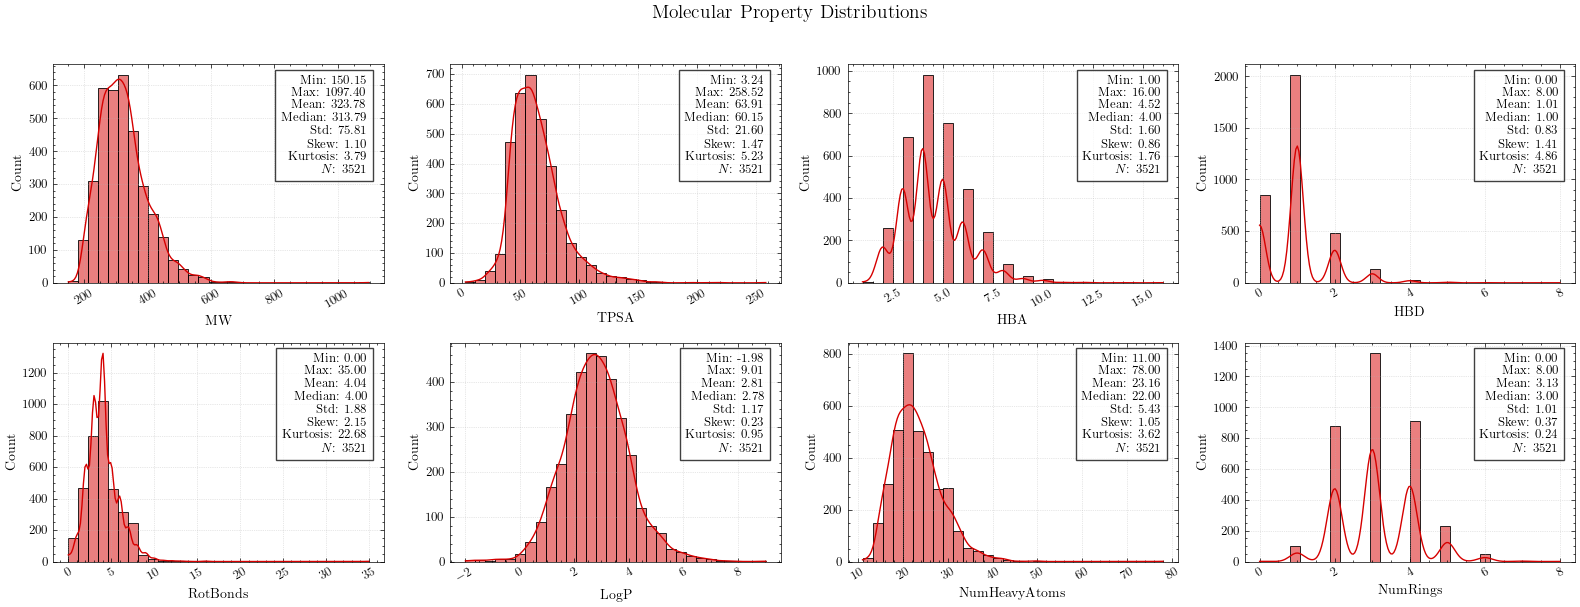

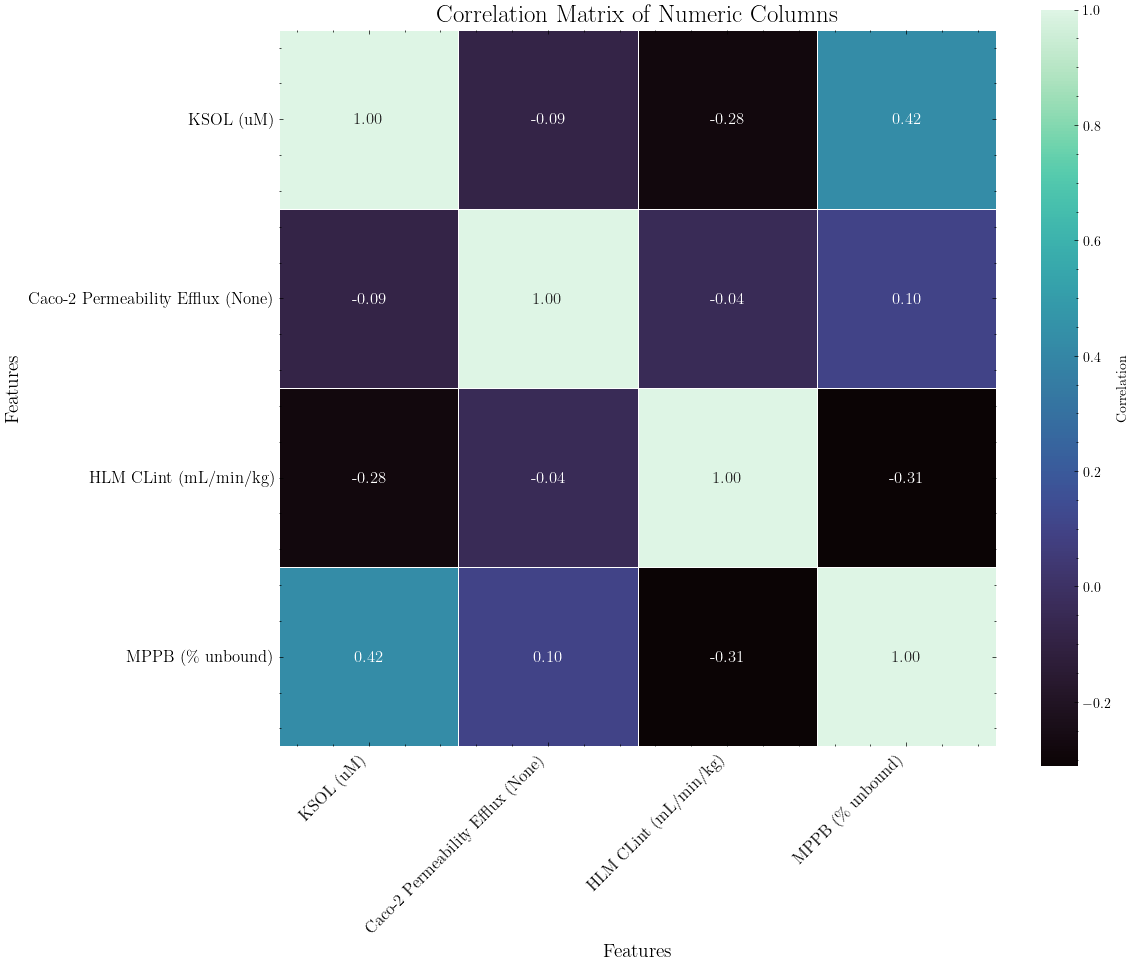

In [27]:
df = df_kermt_biogen_admet_cleaned.copy()
fname = "kermt_biogen_admet_cleaned"

df_props = compute_molecular_properties(df["SMILES"])
output_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plot_endpoint_distributions(
    df,
    n_cols=3,
    title="KERMT Biogen ADMET Cleaned Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

### PharmaBench

In [28]:
files_pharmabench: Dict[str, str] = {
    "LogD": "PharmaBench/final_datasets/logd_reg_final_data.csv",
    "KSOL": "PharmaBench/final_datasets/water_sol_reg_final_data.csv",  # log_10(nM)
    "HLM CLint": "PharmaBench/final_datasets/hum_mic_cl_reg_final_data.csv",  # log10(mL/min/g)
    "MLM CLint": "PharmaBench/final_datasets/mou_mic_cl_reg_final_data.csv",  # log10(mL/min/g)
    "MPPB": "PharmaBench/final_datasets/ppb_reg_final_data.csv",  # %
}

smiles_col = "Smiles_unify"
target_col = "value"

df_pharmabench_admet_cleaned = pd.DataFrame()
for admet_property, file_path in files_pharmabench.items():
    logger.info(f"Processing PharmaBench ADMET property: {admet_property}")
    data_path = base_data_dir / file_path
    df_property = pd.read_csv(data_path)

    # drop rows with invalid SMILES
    df_property[smiles_col] = parallel_canonicalize_smiles(
        df_property[smiles_col].tolist(),
        isomeric=True,
    )
    n_none_smiles = df_property[smiles_col].isnull().sum()
    if n_none_smiles > 0:
        logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES for property {admet_property}")
        df_property.dropna(subset=[smiles_col], inplace=True)
        df_property.reset_index(drop=True, inplace=True)

    logger.info(f"PharmaBench Dataframe for {admet_property} shape: {df_property.shape}")
    logger.info(f"PharmaBench Dataframe for {admet_property} columns: {df_property.columns.tolist()}")

    df_property_admet_cleaned = df_property[[smiles_col, target_col]].copy()
    if admet_property == "KSOL":
        output_col = f"{admet_property} (uM)"
        df_property_admet_cleaned[output_col] = (
            df_property_admet_cleaned[target_col].apply(TRANSFORMATIONS["10^(x)"]).apply(TRANSFORMATIONS["nM to uM"])
        )
    elif admet_property in ["MLM CLint", "HLM CLint"]:
        output_col = f"{admet_property} (mL/min/kg)"
        df_property_admet_cleaned[output_col] = df_property_admet_cleaned[target_col].apply(
            TRANSFORMATIONS["10^(x)"]
        )  # .apply(TRANSFORMATIONS["kg to g"])
    elif admet_property == "LogD":
        output_col = f"{admet_property} (None)"
        df_property_admet_cleaned[output_col] = df_property_admet_cleaned[target_col].apply(TRANSFORMATIONS["None"])
    elif admet_property == "MPPB":
        output_col = f"{admet_property} (% unbound)"
        df_property_admet_cleaned[output_col] = df_property_admet_cleaned[target_col].apply(TRANSFORMATIONS["None"])
    else:
        raise ValueError(f"Unknown ADMET property: {admet_property}")

    df_property_admet_cleaned.rename(columns={smiles_col: "SMILES"}, inplace=True)
    df_property_admet_cleaned.drop(columns=[target_col], inplace=True)
    logger.info(f"Transformed column '{target_col}' to '{output_col}' with {len(df_property_admet_cleaned)} entries.")
    if df_pharmabench_admet_cleaned.empty:
        df_pharmabench_admet_cleaned = df_property_admet_cleaned
    else:
        df_pharmabench_admet_cleaned = pd.merge(
            df_pharmabench_admet_cleaned,
            df_property_admet_cleaned,
            on="SMILES",
            how="outer",
        )
logger.info(f"PharmaBench-ExpansionRX Dataframe shape: {df_pharmabench_admet_cleaned.shape}")
logger.info(f"PharmaBench-ExpansionRX Dataframe columns: {df_pharmabench_admet_cleaned.columns.tolist()}")

2025-11-28 10:20:44,552 - __main__ - INFO - Processing PharmaBench ADMET property: LogD


Canonicalizing SMILES:   0%|          | 0/13068 [00:00<?, ?it/s]

2025-11-28 10:20:48,604 - __main__ - INFO - PharmaBench Dataframe for LogD shape: (13068, 6)
2025-11-28 10:20:48,604 - __main__ - INFO - PharmaBench Dataframe for LogD columns: ['index', 'Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-28 10:20:48,607 - __main__ - INFO - Transformed column 'value' to 'LogD (None)' with 13068 entries.
2025-11-28 10:20:48,608 - __main__ - INFO - Processing PharmaBench ADMET property: KSOL


Canonicalizing SMILES:   0%|          | 0/11701 [00:00<?, ?it/s]

2025-11-28 10:20:51,559 - __main__ - INFO - PharmaBench Dataframe for KSOL shape: (11701, 6)
2025-11-28 10:20:51,559 - __main__ - INFO - PharmaBench Dataframe for KSOL columns: ['index', 'Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-28 10:20:51,571 - __main__ - INFO - Transformed column 'value' to 'KSOL (uM)' with 11701 entries.
2025-11-28 10:20:51,589 - __main__ - INFO - Processing PharmaBench ADMET property: HLM CLint


Canonicalizing SMILES:   0%|          | 0/2286 [00:00<?, ?it/s]

2025-11-28 10:20:52,310 - __main__ - INFO - PharmaBench Dataframe for HLM CLint shape: (2286, 7)
2025-11-28 10:20:52,311 - __main__ - INFO - PharmaBench Dataframe for HLM CLint columns: ['Unnamed: 0', 'index', 'Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-28 10:20:52,314 - __main__ - INFO - Transformed column 'value' to 'HLM CLint (mL/min/kg)' with 2286 entries.
2025-11-28 10:20:52,333 - __main__ - INFO - Processing PharmaBench ADMET property: MLM CLint


Canonicalizing SMILES:   0%|          | 0/1403 [00:00<?, ?it/s]

2025-11-28 10:20:52,715 - __main__ - INFO - PharmaBench Dataframe for MLM CLint shape: (1403, 7)
2025-11-28 10:20:52,715 - __main__ - INFO - PharmaBench Dataframe for MLM CLint columns: ['Unnamed: 0', 'index', 'Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-28 10:20:52,717 - __main__ - INFO - Transformed column 'value' to 'MLM CLint (mL/min/kg)' with 1403 entries.
2025-11-28 10:20:52,736 - __main__ - INFO - Processing PharmaBench ADMET property: MPPB


Canonicalizing SMILES:   0%|          | 0/1262 [00:00<?, ?it/s]

2025-11-28 10:20:53,099 - __main__ - INFO - PharmaBench Dataframe for MPPB shape: (1262, 5)
2025-11-28 10:20:53,099 - __main__ - INFO - PharmaBench Dataframe for MPPB columns: ['Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-28 10:20:53,100 - __main__ - INFO - Transformed column 'value' to 'MPPB (% unbound)' with 1262 entries.
2025-11-28 10:20:53,120 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape: (27611, 6)
2025-11-28 10:20:53,120 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe columns: ['SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'MPPB (% unbound)']


In [29]:
# drop rows with invalid SMILES
df_pharmabench_admet_cleaned["SMILES"] = parallel_canonicalize_smiles(
    df_pharmabench_admet_cleaned["SMILES"].tolist(),
    isomeric=True,
)

n_none_smiles = df_pharmabench_admet_cleaned["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_pharmabench_admet_cleaned.dropna(subset=["SMILES"], inplace=True)
    df_pharmabench_admet_cleaned.reset_index(drop=True, inplace=True)
logger.info(f"PharmaBench-ExpansionRX Dataframe shape after cleaning: {df_pharmabench_admet_cleaned.shape}")

Canonicalizing SMILES:   0%|          | 0/27611 [00:00<?, ?it/s]

2025-11-28 10:21:01,073 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape after cleaning: (27611, 6)


In [30]:
# log10 transform all targets except LogD
for col in df_pharmabench_admet_cleaned.columns:
    if col in ["LogD (None)", "SMILES"]:
        continue
    else:
        logger.info(f"Log10 transforming column: {col}")
        df_pharmabench_admet_cleaned[col] = df_pharmabench_admet_cleaned[col].apply(TRANSFORMATIONS["log10(x)"])
        logger.info(f"Transformed column: {col} with log10")

2025-11-28 10:21:01,122 - __main__ - INFO - Log10 transforming column: KSOL (uM)
2025-11-28 10:21:01,142 - __main__ - INFO - Transformed column: KSOL (uM) with log10
2025-11-28 10:21:01,142 - __main__ - INFO - Log10 transforming column: HLM CLint (mL/min/kg)
2025-11-28 10:21:01,161 - __main__ - INFO - Transformed column: HLM CLint (mL/min/kg) with log10
2025-11-28 10:21:01,161 - __main__ - INFO - Log10 transforming column: MLM CLint (mL/min/kg)
2025-11-28 10:21:01,180 - __main__ - INFO - Transformed column: MLM CLint (mL/min/kg) with log10
2025-11-28 10:21:01,180 - __main__ - INFO - Log10 transforming column: MPPB (% unbound)
2025-11-28 10:21:01,198 - __main__ - INFO - Transformed column: MPPB (% unbound) with log10


In [31]:
# compute molecular properties
df_props = compute_molecular_properties(df_pharmabench_admet_cleaned["SMILES"])

# drop rows with MW > 1000
idx_high_mw = df_props["MW"] > 1000.0
if idx_high_mw.sum() > 0:
    logger.warning(f"Dropping {idx_high_mw.sum()} rows with MW > 1000 g/mol")
    df_pharmabench_admet_cleaned = df_pharmabench_admet_cleaned[~idx_high_mw].reset_index(drop=True)
    logger.info(f"PharmaBench-ExpansionRX Dataframe shape after dropping high MW: {df_pharmabench_admet_cleaned.shape}")
df_props = df_props.loc[df_pharmabench_admet_cleaned.index].reset_index(drop=True)

# drop rows with -2 < LogP < 8
idx_invalid_logp = (df_props["LogP"] < -2.0) | (df_props["LogP"] > 8.0)
if idx_invalid_logp.sum() > 0:
    logger.warning(f"Dropping {idx_invalid_logp.sum()} rows with invalid LogP values")
    df_pharmabench_admet_cleaned = df_pharmabench_admet_cleaned[~idx_invalid_logp].reset_index(drop=True)
    logger.info(
        f"PharmaBench-ExpansionRX Dataframe shape after dropping invalid LogP: {df_pharmabench_admet_cleaned.shape}"
    )
df_props = df_props.loc[df_pharmabench_admet_cleaned.index].reset_index(drop=True)

# drop rows with rotatable bonds > 20
idx_too_many_rot_bonds = df_props["RotBonds"] > 20
if idx_too_many_rot_bonds.sum() > 0:
    logger.warning(f"Dropping {idx_too_many_rot_bonds.sum()} rows with too many rotatable bonds")
    df_pharmabench_admet_cleaned = df_pharmabench_admet_cleaned[~idx_too_many_rot_bonds].reset_index(drop=True)
    logger.info(
        f"PharmaBench-ExpansionRX Dataframe shape after dropping too many rotatable bonds: {df_pharmabench_admet_cleaned.shape}"
    )
df_props = df_props.loc[df_pharmabench_admet_cleaned.index].reset_index(drop=True)

Computing molecular properties:   0%|          | 0/27611 [00:00<?, ?molecule/s]

2025-11-28 10:21:12,239 - __main__ - WARNING - Dropping 82 rows with MW > 1000 g/mol
2025-11-28 10:21:12,240 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape after dropping high MW: (27529, 6)
2025-11-28 10:21:12,242 - __main__ - WARNING - Dropping 277 rows with invalid LogP values
2025-11-28 10:21:12,243 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape after dropping invalid LogP: (27252, 6)
2025-11-28 10:21:12,244 - __main__ - WARNING - Dropping 120 rows with too many rotatable bonds
2025-11-28 10:21:12,245 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape after dropping too many rotatable bonds: (27132, 6)


In [32]:
# export data
logger.info(f"PharmaBench-ExpansionRX Dataframe shape: {df_pharmabench_admet_cleaned.shape}")
cleaned_data["pharmabench"] = df_pharmabench_admet_cleaned.copy()

2025-11-28 10:21:13,211 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape: (27132, 6)


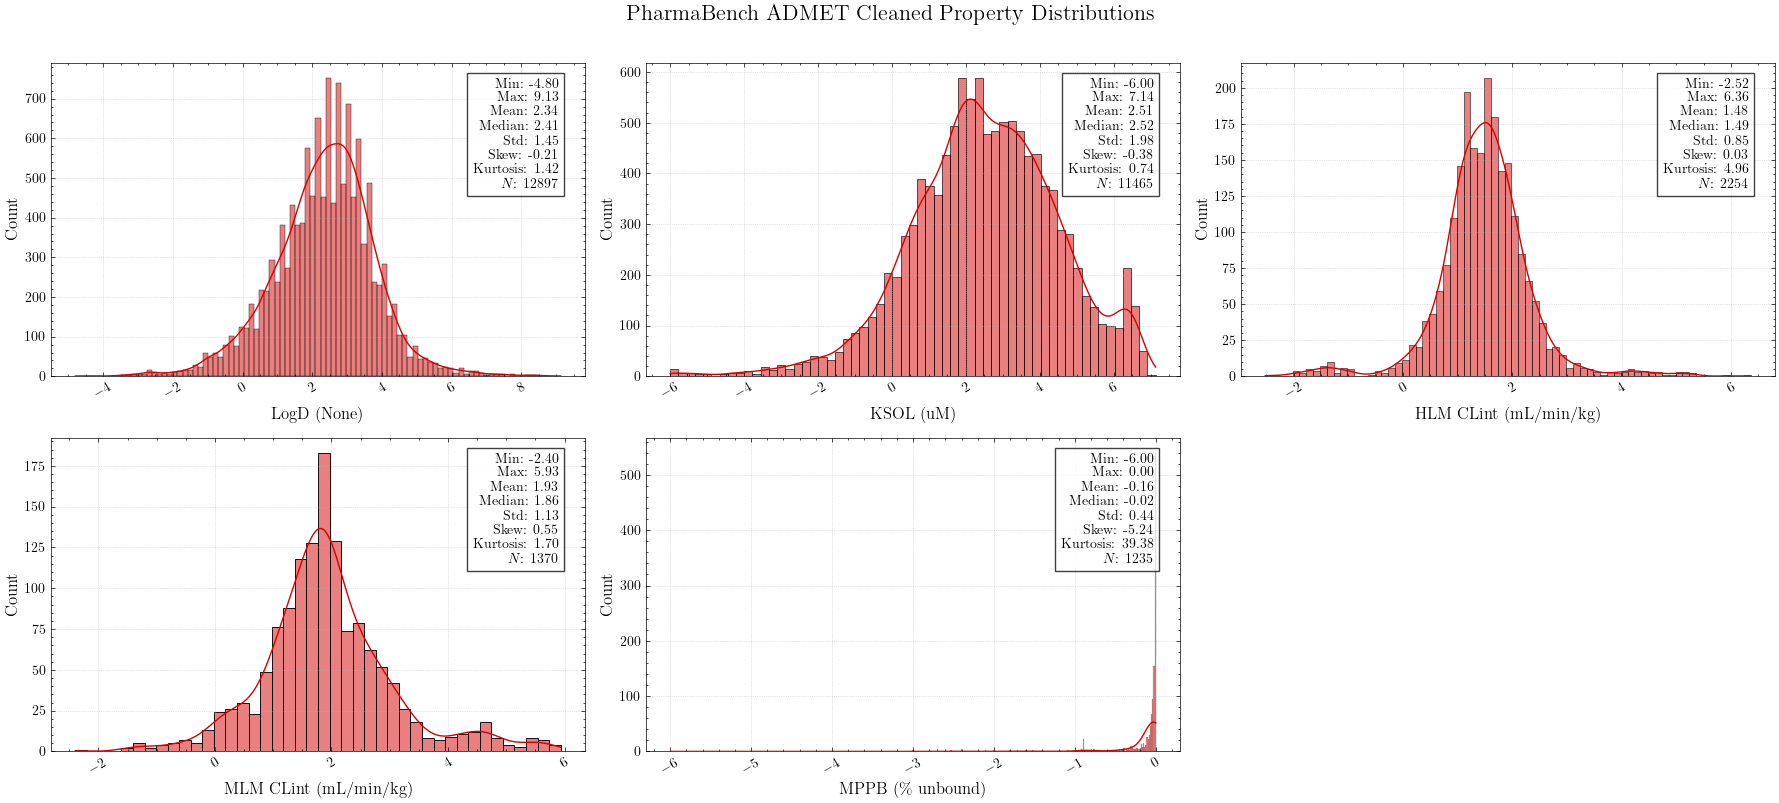

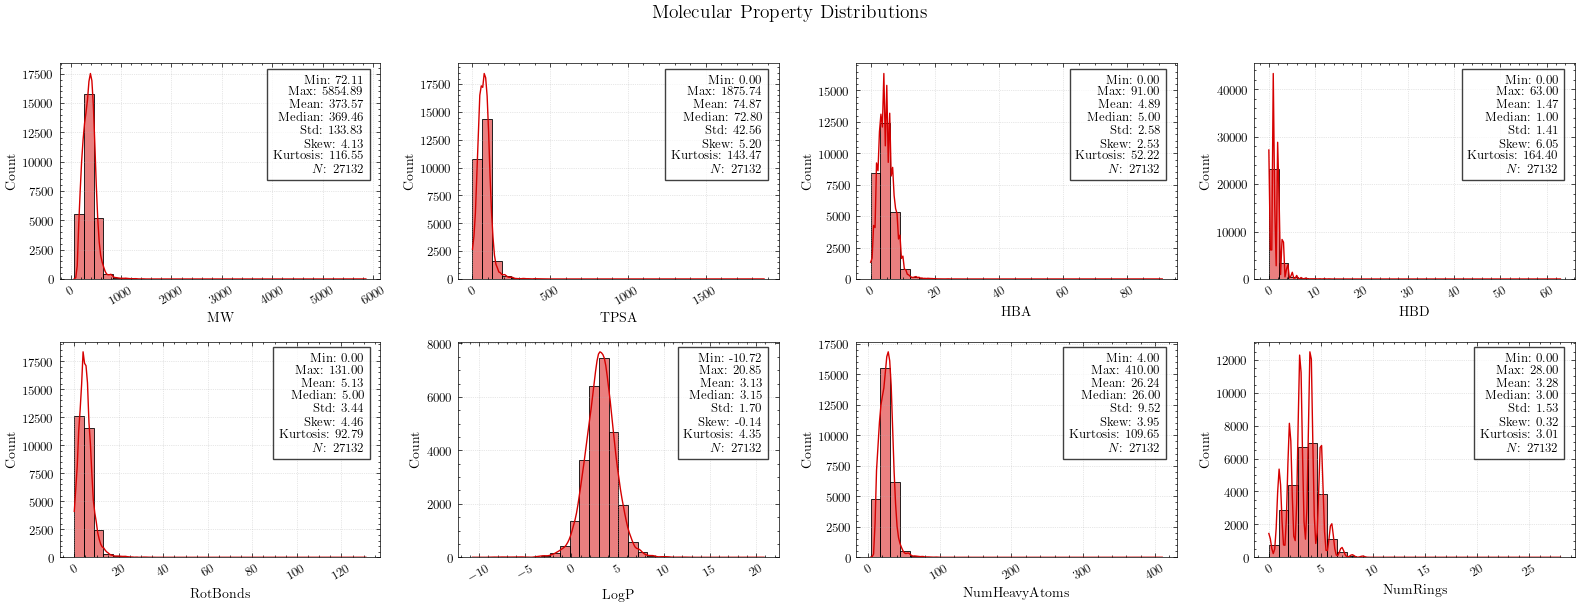

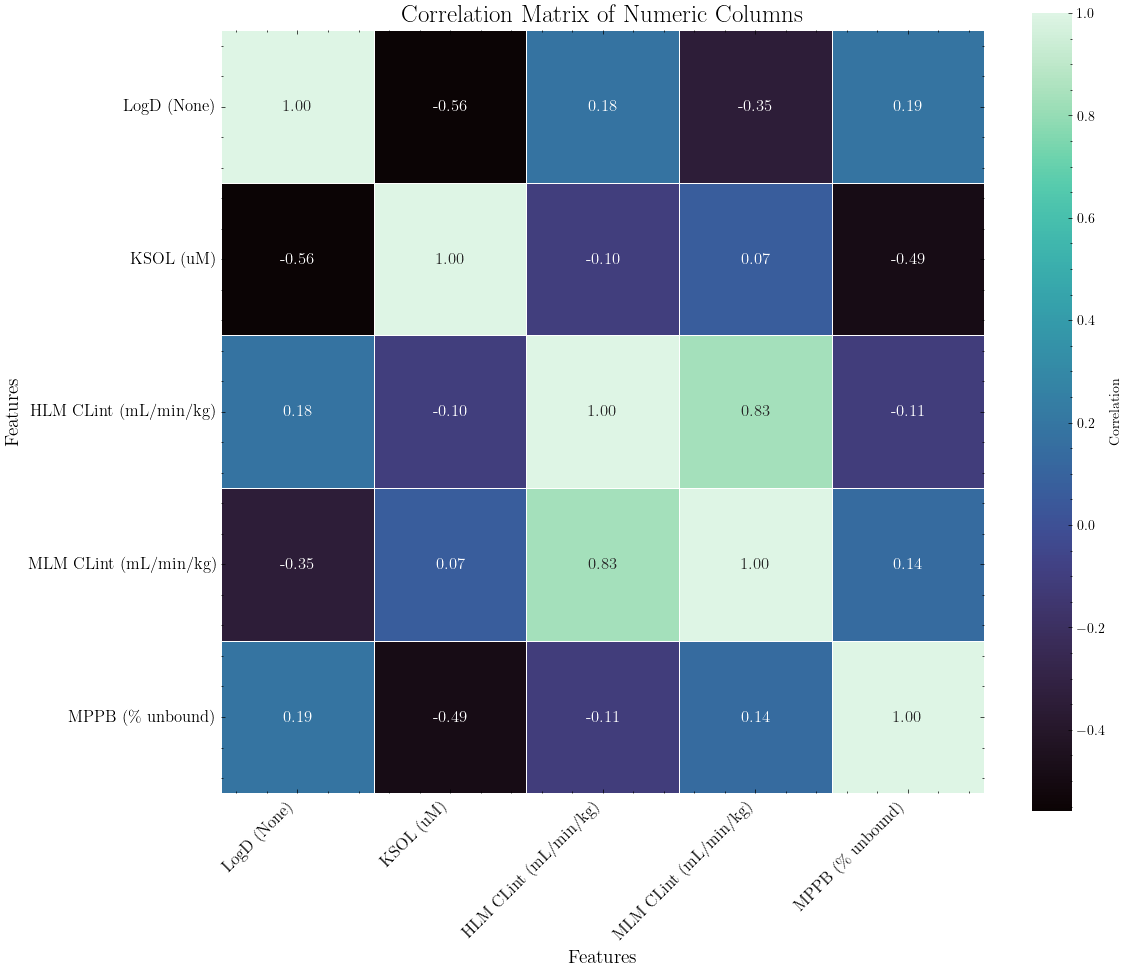

In [33]:
df = df_pharmabench_admet_cleaned.copy()
fname = "pharmabench_admet_cleaned"

output_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plot_endpoint_distributions(
    df,
    n_cols=3,
    title="PharmaBench ADMET Cleaned Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

### Admetica

In [34]:
# REVIEW: Consider adding this dataset later

### TDC

In [35]:
# TODO: Implement loading and processing

### NCATS

In [36]:
# REVIEW: Consider adding this dataset later

### ChEMBL

In [37]:
# REVIEW: Consider adding this dataset later

## Merge Datasets

In [38]:
# merge all cleaned datasets
df_out = pd.DataFrame()
for dataset_name, df_cleaned in cleaned_data.items():
    df = df_cleaned.copy()
    logger.info(f"Merging cleaned dataset: {dataset_name} with shape {df_cleaned.shape}")

    # drop rows with all endpoints NaN (excluding SMILES)
    target_cols = [col for col in df.columns if col not in ["SMILES"]]
    idx_all_nan = df[target_cols].isna().all(axis=1)
    n_all_nan = idx_all_nan.sum()
    if n_all_nan > 0:
        logger.warning(f"Dropping {n_all_nan} rows with all target values NaN in dataset {dataset_name}")
        df = df[~idx_all_nan].reset_index(drop=True)
        logger.info(f"Dataframe shape after dropping all-NaN rows: {df.shape}")

    # drop units from column names
    df.rename(
        columns={col: col.split("(")[0].strip() for col in df.columns if "(" in col},
        inplace=True,
    )

    # prepend "Log " to non-SMILES, LogD columns to avoid name clashes
    df.rename(
        columns={col: f"Log {col}" if col not in ["SMILES", "LogD", "Molecule Name"] else col for col in df.columns},
        inplace=True,
    )

    # add dataset column
    df["Dataset"] = dataset_name
    # prepend to merged dataframe
    df = df[["Dataset"] + [col for col in df.columns if col != "Dataset"]]

    if df_out.empty:
        df_out = df.copy()
    else:
        df_out = pd.concat([df_out, df], ignore_index=True)

2025-11-28 10:21:19,999 - __main__ - INFO - Merging cleaned dataset: expansionrx with shape (5326, 11)
2025-11-28 10:21:20,003 - __main__ - INFO - Merging cleaned dataset: kermt_public with shape (114065, 8)
2025-11-28 10:21:20,004 - __main__ - WARNING - Dropping 24319 rows with all target values NaN in dataset kermt_public
2025-11-28 10:21:20,009 - __main__ - INFO - Dataframe shape after dropping all-NaN rows: (89746, 8)
2025-11-28 10:21:20,017 - __main__ - INFO - Merging cleaned dataset: kermt_biogen with shape (3521, 5)
2025-11-28 10:21:20,018 - __main__ - WARNING - Dropping 167 rows with all target values NaN in dataset kermt_biogen
2025-11-28 10:21:20,018 - __main__ - INFO - Dataframe shape after dropping all-NaN rows: (3354, 5)
2025-11-28 10:21:20,021 - __main__ - INFO - Merging cleaned dataset: pharmabench with shape (27132, 6)


In [39]:
logger.info(f"Merged cleaned dataframe shape: {df_out.shape}")
logger.debug(f"Merged cleaned dataframe columns: {df_out.columns.tolist()}")
df_out

2025-11-28 10:21:20,165 - __main__ - INFO - Merged cleaned dataframe shape: (125558, 12)
2025-11-28 10:21:20,165 - __main__ - DEBUG - Merged cleaned dataframe columns: ['Dataset', 'Molecule Name', 'SMILES', 'LogD', 'Log KSOL', 'Log HLM CLint', 'Log MLM CLint', 'Log Caco-2 Permeability Papp A>B', 'Log Caco-2 Permeability Efflux', 'Log MPPB', 'Log MBPB', 'Log MGMB']


Dataset Molecule Name  \
0       expansionrx     E-0001321   
1       expansionrx     E-0001780   
2       expansionrx     E-0001827   
3       expansionrx     E-0002019   
4       expansionrx     E-0002036   
...             ...           ...   
125553  pharmabench           NaN   
125554  pharmabench           NaN   
125555  pharmabench           NaN   
125556  pharmabench           NaN   
125557  pharmabench           NaN   

                                                   SMILES  LogD  Log KSOL  \
0       CN1CCC[C@H]1COc1ccc(-c2nc3cc(-c4ccc5[nH]c(-c6c...   NaN       NaN   
1                       COc1ccc2c(c1)c1cc3cnccc3c(C)c1n2C   NaN       NaN   
2          Cc1c2ccncc2cc2c3cc(OCCCN4CCN(C)CC4)ccc3n(C)c12   NaN       NaN   
3       CN(C)CCCOc1ccc(-c2nc3cc(NC(=O)c4ccc5[nH]c(-c6c...   NaN       NaN   
4       CN(C)CCCOc1ccc2nc(-c3ccc(-c4nc5ccc(OCCCN(C)C)c...   NaN       NaN   
...                                                   ...   ...       ...   
125553               c1nc2c(N3CCOCC3)nc(Nc3ccsc3)nc2[nH]1   NaN    1.7404   
125554                 c1nc2c(NC3CC3)nc(Nc3ccsc3)nc2[nH]1   NaN    2.4829   
125555               c1nc2c(NC3CCCC3)nc(Nc3ccsc3)nc2[nH]1   NaN    1.5185   
125556              c1nc2c(NC3CCCCC3)nc(Nc3ccsc3)nc2[nH]1   NaN    1.7559   
125557             c1nc2c(NCCN3CCCC3)nc(Nc3ccsc3)nc2[nH]1   NaN    2.7356   

        Log HLM CLint  Log MLM CLint  Log Caco-2 Permeability Papp A>B  \
0            1.751279       2.260787                               NaN   
1            2.205204       3.130687                               NaN   
2                 NaN       2.286681                               NaN   
3            0.977724            NaN                               NaN   
4                 NaN       2.209515                               NaN   
...               ...            ...                               ...   
125553            NaN            NaN                               NaN   
125554            NaN            NaN                               NaN   
125555            NaN            NaN                               NaN   
125556            NaN            NaN                               NaN   
125557            NaN            NaN                               NaN   

        Log Caco-2 Permeability Efflux  Log MPPB  Log MBPB  Log MGMB  
0                                  NaN       NaN       NaN       NaN  
1                                  NaN       NaN       NaN       NaN  
2                                  NaN       NaN       NaN       NaN  
3                                  NaN       NaN       NaN       NaN  
4                                  NaN       NaN       NaN -1.913605  
...                                ...       ...       ...       ...  
125553                             NaN       NaN       NaN       NaN  
125554                             NaN       NaN       NaN       NaN  
125555                             NaN       NaN       NaN       NaN  
125556                             NaN       NaN       NaN       NaN  
125557                             NaN       NaN       NaN       NaN  

[125558 rows x 12 columns]

### Quality Control

In [40]:
# add quality table for each dataset (row) and endpoint (column)
quality_table = pd.DataFrame()
quality_table["Dataset"] = cleaned_data.keys()

map_logd_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": "medium",
    "pharmabench": "medium",
}
map_ksol_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": "low",
    "pharmabench": "low",
}
map_mlm_clint_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": None,
    "pharmabench": "medium",
}
map_hlm_clint_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": "low",
    "pharmabench": "medium",
}
map_caco2_permeability_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": None,
    "pharmabench": None,
}
map_caco2_efflux_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": "medium",
    "pharmabench": None,
}
map_mppb_quality = {
    "expansionrx": "high",
    "kermt_public": "low",
    "kermt_biogen": "medium",
    "pharmabench": "low",
}
map_mbpb_quality = {
    "expansionrx": "high",
    "kermt_public": None,
    "kermt_biogen": None,
    "pharmabench": None,
}
map_mgmb_quality = {
    "expansionrx": "high",
    "kermt_public": None,
    "kermt_biogen": None,
    "pharmabench": None,
}
for idx, row in quality_table.iterrows():
    dataset = row["Dataset"]
    quality_table.loc[idx, "LogD"] = map_logd_quality[dataset]
    quality_table.loc[idx, "Log KSOL"] = map_ksol_quality[dataset]
    quality_table.loc[idx, "Log MLM CLint"] = map_mlm_clint_quality[dataset]
    quality_table.loc[idx, "Log HLM CLint"] = map_hlm_clint_quality[dataset]
    quality_table.loc[idx, "Log Caco-2 Permeability Efflux"] = map_caco2_efflux_quality[dataset]
    quality_table.loc[idx, "Log Caco-2 Permeability Papp A>B"] = map_caco2_permeability_quality[dataset]
    quality_table.loc[idx, "Log MPPB"] = map_mppb_quality[dataset]
    quality_table.loc[idx, "Log MBPB"] = map_mbpb_quality[dataset]
    quality_table.loc[idx, "Log MGMB"] = map_mgmb_quality.get(dataset, None)

logger.info(f"Quality table shape: {quality_table.shape}")
logger.info(f"Quality table columns: {quality_table.columns.tolist()}")


quality_table.to_csv(output_dir / "cleaned_datasets_quality_table.csv", index=False)
quality_table

2025-11-28 10:21:20,388 - __main__ - INFO - Quality table shape: (4, 10)
2025-11-28 10:21:20,388 - __main__ - INFO - Quality table columns: ['Dataset', 'LogD', 'Log KSOL', 'Log MLM CLint', 'Log HLM CLint', 'Log Caco-2 Permeability Efflux', 'Log Caco-2 Permeability Papp A>B', 'Log MPPB', 'Log MBPB', 'Log MGMB']


Dataset    LogD Log KSOL Log MLM CLint Log HLM CLint  \
0   expansionrx    high     high          high          high   
1  kermt_public  medium   medium        medium        medium   
2  kermt_biogen  medium      low          None           low   
3   pharmabench  medium      low        medium        medium   

  Log Caco-2 Permeability Efflux Log Caco-2 Permeability Papp A>B Log MPPB  \
0                           high                             high     high   
1                         medium                           medium      low   
2                         medium                             None   medium   
3                           None                             None      low   

  Log MBPB Log MGMB  
0     high     high  
1     None     None  
2     None     None  
3     None     None

### Filtering

In [41]:
# limit datasets to physically reasonable ranges
df_props = compute_molecular_properties(df_out["SMILES"])

idx_drop = df_props["MW"] > 1000.0

idx_drop |= df_props["LogP"] < -5.0
idx_drop |= df_props["LogP"] > 10.0

idx_drop |= df_props["TPSA"] > 300.0

idx_drop |= df_props["HBA"] > 20

idx_drop |= df_props["HBD"] > 10

idx_drop |= df_props["RotBonds"] > 20

idx_drop |= df_props["NumRings"] > 10

Computing molecular properties:   0%|          | 0/125558 [00:00<?, ?molecule/s]

In [42]:
# Remove exclusions outside of ExpansionRX teaser dataset
idx_challenge = df_out["Dataset"] == "expansionrx"
idx_drop = idx_drop & ~idx_challenge

n_dropped = idx_drop.sum()
if n_dropped > 0:
    logger.warning(f"Dropping {n_dropped} entries from combined dataset due to unreasonable molecular properties")
    df_out = df_out.loc[~idx_drop].copy()

2025-11-28 10:22:07,229 - __main__ - WARNING - Dropping 263 entries from combined dataset due to unreasonable molecular properties


In [43]:
# remove any idx_drop that are in the ExpansionRx teaser dataset
idx_teaser = df_out["Dataset"] == "expansionrx"
idx_drop = idx_drop & ~idx_teaser
# drop entries
n_dropped = idx_drop.sum()
if n_dropped > 0:
    logger.warning(f"Dropping {n_dropped} entries from combined dataset due to unreasonable molecular properties")
    df_out = df_out.loc[~idx_drop].copy()

for name in cleaned_data.keys():
    df_subset = df_out[df_out["Dataset"] == name]

    # check for repeated SMILES inside a dataset
    n_total = len(df_subset)
    n_unique = df_subset["SMILES"].nunique()
    n_duplicates = n_total - n_unique
    if n_duplicates > 0:
        logger.warning(f"Found {n_duplicates} duplicate SMILES in combined dataset for dataset '{name}'")
        # average (skip NaNs) over duplicates
        df_subset = df_subset.groupby("SMILES", as_index=False).mean(numeric_only=True)
        # update in main dataframe
        df_out = pd.concat(
            [df_out[df_out["Dataset"] != name], df_subset],
            axis=0,
        )
        logger.info(f"Dataframe shape after averaging duplicates for dataset '{name}': {df_out.shape}")

In [44]:
def quality_rank(quality: str) -> int:
    rank_map = {
        "high": 3,
        "medium": 2,
        "low": 1,
        None: 0,
    }
    rank = rank_map.get(quality, -1)
    if rank == -1:
        raise ValueError(f"Unknown quality string: {quality}")
    return rank


def rank_to_quality(rank: int) -> str:
    rank_map = {
        3: "high",
        2: "medium",
        1: "low",
        0: None,
    }
    rank = rank_map.get(rank, "Unknown")
    if rank == "Unknown":
        raise ValueError(f"Unknown quality rank: {rank}")
    return rank

In [45]:
# look for any remaining duplicates
n_total = len(df_out)
n_unique = df_out["SMILES"].nunique()
n_duplicates = n_total - n_unique
if n_duplicates > 0:
    logger.warning(f"Found {n_duplicates} duplicate SMILES in final combined dataframe")

2025-11-28 10:22:07,489 - __main__ - WARNING - Found 5497 duplicate SMILES in final combined dataframe


In [46]:
quality_columns = [col for col in quality_table.columns if col not in ["SMILES", "Dataset"]]
quality_columns_set = set(quality_columns)
logger.info(f"Quality columns to consider: {quality_columns}")
logger.info("Dataframe columns: {}".format(df_out.columns.tolist()))

2025-11-28 10:22:07,542 - __main__ - INFO - Quality columns to consider: ['LogD', 'Log KSOL', 'Log MLM CLint', 'Log HLM CLint', 'Log Caco-2 Permeability Efflux', 'Log Caco-2 Permeability Papp A>B', 'Log MPPB', 'Log MBPB', 'Log MGMB']
2025-11-28 10:22:07,542 - __main__ - INFO - Dataframe columns: ['Dataset', 'Molecule Name', 'SMILES', 'LogD', 'Log KSOL', 'Log HLM CLint', 'Log MLM CLint', 'Log Caco-2 Permeability Papp A>B', 'Log Caco-2 Permeability Efflux', 'Log MPPB', 'Log MBPB', 'Log MGMB']


In [47]:
qualities = pd.Series(dtype=object, index=df_out.index)
for idx, row in tqdm(df_out.iterrows(), total=len(df_out)):
    idx = int(idx)
    dataset = row["Dataset"]

    # find finite columns for this row
    finite_cols = [c for c in df_out.columns if c not in ["SMILES", "Dataset", "Quality"] and pd.notna(row[c])]
    finits_cols_set = set(finite_cols)
    if len(finite_cols) == 0:
        qualities[idx] = "No Data"
        continue

    # check the intersection of finite columns and quality columns
    relevant_quality_columns = quality_columns_set.intersection(finits_cols_set)
    if len(relevant_quality_columns) == 0:
        qualities[idx] = "No Quality"
        continue

    # get qualities for relevant columns
    quals = []
    for col in relevant_quality_columns:
        quality = quality_table.loc[quality_table["Dataset"] == dataset, col].values[0]
        quals.append(quality)

    # get minimum quality
    quality_ranks = [quality_rank(q) for q in quals if q is not None]
    if len(quality_ranks) == 0:
        min_quality = "No Quality Minimum"
        logger.debug(f"All qualities are None for index {idx} with dataset {dataset}, setting Quality to None")
    else:
        min_rank = min(quality_ranks)
        min_quality = rank_to_quality(min_rank)

    qualities[idx] = min_quality

df_out["Quality"] = qualities
logger.info(f"Counts of final quality levels:\n{df_out['Quality'].value_counts()}")

  0%|          | 0/125295 [00:00<?, ?it/s]

2025-11-28 10:22:32,694 - __main__ - INFO - Counts of final quality levels:
Quality
medium        103901
low            16068
high            5324
No Quality         2
Name: count, dtype: int64


In [48]:
# drop no quality rows
idx_no_quality = (
    df_out["Quality"].isna()
    | (df_out["Quality"] == "No Quality")
    | (df_out["Quality"] == "No Data")
    | (df_out["Quality"] == "No Quality Minimum")
)
n_no_quality = idx_no_quality.sum()
if n_no_quality > 0:
    logger.warning(f"Dropping {n_no_quality} rows with no quality assigned")
    df_out = df_out[~idx_no_quality].reset_index(drop=True)
    logger.info(f"Final dataframe shape after dropping no-quality rows: {df_out.shape}")

# print number of expansionrx entries remaining
n_expansionrx = (df_out["Dataset"] == "expansionrx").sum()
logger.info(f"Number of ExpansionRx entries remaining in final dataframe: {n_expansionrx}")

2025-11-28 10:22:32,969 - __main__ - WARNING - Dropping 2 rows with no quality assigned
2025-11-28 10:22:32,986 - __main__ - INFO - Final dataframe shape after dropping no-quality rows: (125293, 13)
2025-11-28 10:22:32,993 - __main__ - INFO - Number of ExpansionRx entries remaining in final dataframe: 5324


In [49]:
# for duplicates, keep quality in order of high > medium > low > None
# to break ties, keep dataset in order of expansionrx > kermt_public > kermt_biogen > pharmabench
dataset_priority = {
    "expansionrx": 4,
    "kermt_public": 3,
    "kermt_biogen": 2,
    "pharmabench": 1,
}
df_out["DatasetPriority"] = df_out["Dataset"].map(dataset_priority)
df_out["QualityRank"] = df_out["Quality"].apply(quality_rank)
df_out.sort_values(
    by=["SMILES", "QualityRank", "DatasetPriority"],
    ascending=[True, False, False],
    inplace=True,
)
df_out = df_out.groupby("SMILES", as_index=False).first()
df_out.drop(columns=["DatasetPriority", "QualityRank"], inplace=True)

logger.info(f"Final cleaned dataframe shape: {df_out.shape}")
logger.debug(f"Final cleaned dataframe columns: {df_out.columns.tolist()}")

# check that there are no duplicate SMILES
n_total = len(df_out)
n_unique = df_out["SMILES"].nunique()
n_duplicates = n_total - n_unique
if n_duplicates > 0:
    logger.error(f"Found {n_duplicates} duplicate SMILES in final cleaned dataframe after deduplication!")
    raise ValueError("Duplicate SMILES found in final cleaned dataframe after deduplication!")


# move Quality column to after dataset
cols = df_out.columns.tolist()
cols.remove("Quality")
cols.insert(2, "Quality")
df_out = df_out[cols]

# count numner of expansionrx entries
n_expansionrx = (df_out["Dataset"] == "expansionrx").sum()
logger.info(f"Number of ExpansionRx entries in final cleaned dataframe: {n_expansionrx}")

2025-11-28 10:22:33,263 - __main__ - INFO - Final cleaned dataframe shape: (119796, 13)
2025-11-28 10:22:33,263 - __main__ - DEBUG - Final cleaned dataframe columns: ['SMILES', 'Dataset', 'Molecule Name', 'LogD', 'Log KSOL', 'Log HLM CLint', 'Log MLM CLint', 'Log Caco-2 Permeability Papp A>B', 'Log Caco-2 Permeability Efflux', 'Log MPPB', 'Log MBPB', 'Log MGMB', 'Quality']
2025-11-28 10:22:33,293 - __main__ - INFO - Number of ExpansionRx entries in final cleaned dataframe: 5324


In [50]:
df_out

SMILES       Dataset  \
0                      Br/C(C=NNc1ccc2nncn2n1)=C\c1ccccc1  kermt_public   
1                     BrC(=C\c1ccccc1)/C=N/Nc1ccc2nncn2n1  kermt_public   
2                            BrC(=C\c1ccccc1)/C=N/n1cnnc1  kermt_public   
3                               BrC(C=Nn1cnnc1)=Cc1ccccc1  kermt_public   
4                       Brc1c(-c2ccc3c(c2)OCO3)nc2ncccn12  kermt_public   
...                                                   ...           ...   
119791                 c1ncc2cc(-n3ccc(OCC4CNC4)n3)ccc2n1   expansionrx   
119792             c1ncc2ccc(-c3ccc(OCCN4CCCCC4)cc3)cc2n1   expansionrx   
119793  c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...  kermt_biogen   
119794                          c1nnc(-c2ccc3c(c2)OCO3)o1  kermt_public   
119795             c1sc(NCC2CCCO2)nc1C12CC3CC(CC(C3)C1)C2  kermt_biogen   

       Quality Molecule Name  LogD  Log KSOL  Log HLM CLint  Log MLM CLint  \
0       medium          None   NaN  0.860000            NaN            NaN   
1       medium          None   NaN  0.860000            NaN            NaN   
2       medium          None   NaN  1.350000            NaN            NaN   
3       medium          None   NaN  1.350000            NaN            NaN   
4       medium          None   NaN  2.090000            NaN            NaN   
...        ...           ...   ...       ...            ...            ...   
119791    high     E-0015659  -1.3  2.454845       1.252853       3.145041   
119792    high     E-0014332   2.3  2.369216       1.720159       2.212188   
119793     low          None   NaN       NaN       1.985754            NaN   
119794  medium          None   NaN  2.030000            NaN            NaN   
119795     low          None   NaN       NaN       1.659650            NaN   

        Log Caco-2 Permeability Papp A>B  Log Caco-2 Permeability Efflux  \
0                                    NaN                             NaN   
1                                    NaN                             NaN   
2                                    NaN                             NaN   
3                                    NaN                             NaN   
4                                    NaN                             NaN   
...                                  ...                             ...   
119791                          0.808211                        0.448706   
119792                               NaN                             NaN   
119793                               NaN                        0.435376   
119794                               NaN                             NaN   
119795                               NaN                             NaN   

        Log MPPB  Log MBPB  Log MGMB  
0            NaN       NaN       NaN  
1            NaN       NaN       NaN  
2            NaN       NaN       NaN  
3            NaN       NaN       NaN  
4            NaN       NaN       NaN  
...          ...       ...       ...  
119791       NaN       NaN       NaN  
119792       NaN       NaN       NaN  
119793       NaN       NaN       NaN  
119794       NaN       NaN       NaN  
119795       NaN       NaN       NaN  

[119796 rows x 13 columns]

2025-11-28 10:22:33,453 - __main__ - INFO - Dataset counts:
Dataset
kermt_public    89594
pharmabench     21666
expansionrx      5324
kermt_biogen     3212
Name: count, dtype: int64


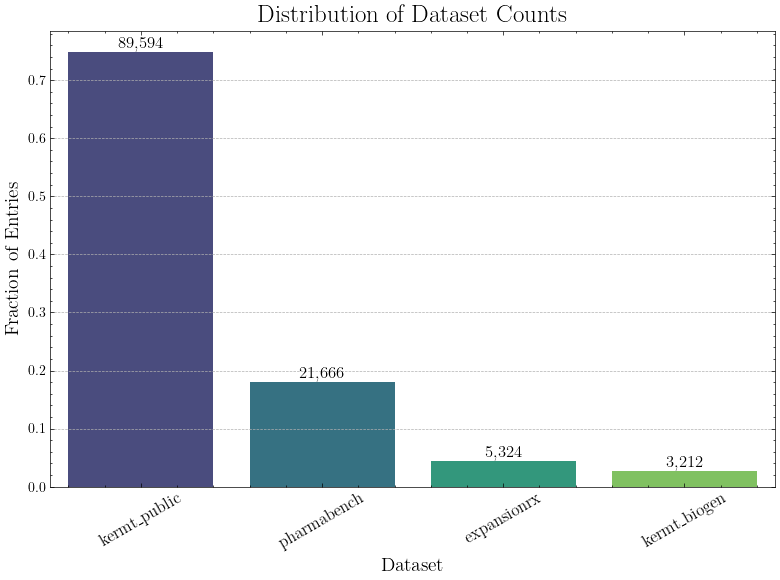

In [51]:
# plot the distribution of dataset counts
dataset_counts = df_out["Dataset"].value_counts()
logger.info(f"Dataset counts:\n{dataset_counts}")
# normalize counts by total number of entries
total_counts = dataset_counts.sum()
dataset_counts = dataset_counts / total_counts

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5)
sns.barplot(
    x=dataset_counts.index,
    y=dataset_counts.values,
    ax=ax,
    palette="viridis",
    hue=dataset_counts.index,
    dodge=False,
)
ax.set_xlabel("Dataset", fontsize=14)
ax.set_ylabel("Fraction of Entries", fontsize=14)
ax.set_title("Distribution of Dataset Counts", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)

# add labels with raw counts on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height * total_counts):,}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=12,
    )

fig.tight_layout()
fig.savefig(output_dir / "combined_dataset_counts.png", dpi=300)

2025-11-28 10:22:33,994 - __main__ - INFO - Plotting distribution for target column 'LogD'
2025-11-28 10:22:34,496 - __main__ - DEBUG - Saved distribution plot at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/eda/combined_LogD_distribution.png
2025-11-28 10:22:34,645 - __main__ - INFO - Plotting distribution for target column 'Log KSOL'
2025-11-28 10:22:35,395 - __main__ - DEBUG - Saved distribution plot at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/eda/combined_Log_KSOL_distribution.png
2025-11-28 10:22:35,400 - __main__ - INFO - Plotting distribution for target column 'Log HLM CLint'
2025-11-28 10:22:35,863 - __main__ - DEBUG - Saved distribution plot at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/eda/combined_Log_HLM_CLint_distribution.png
2025-11-28 10:22:35,867 - __main__ - INFO

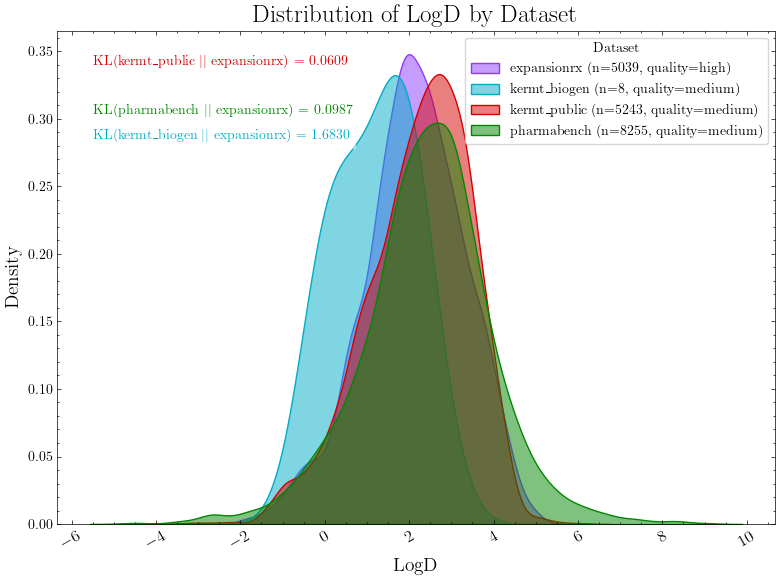

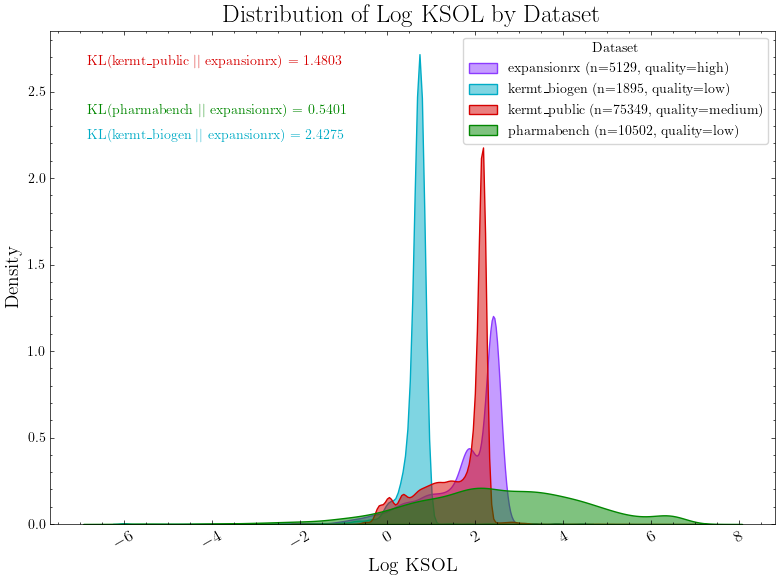

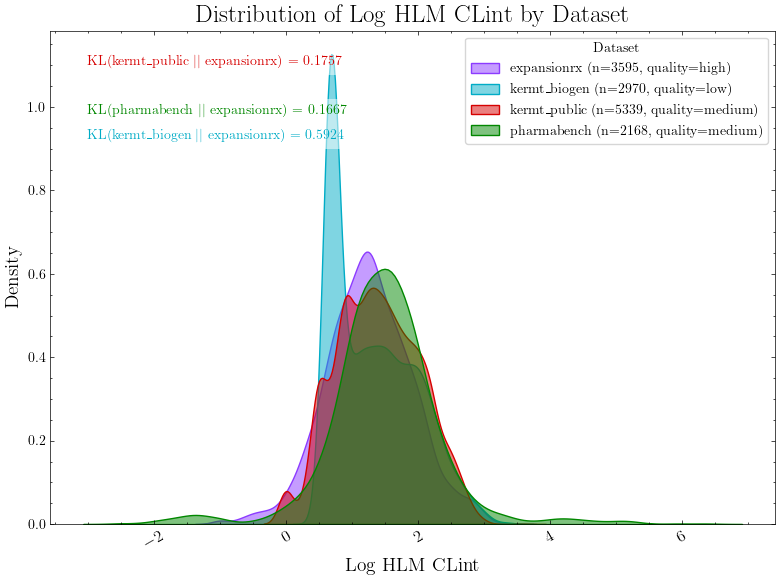

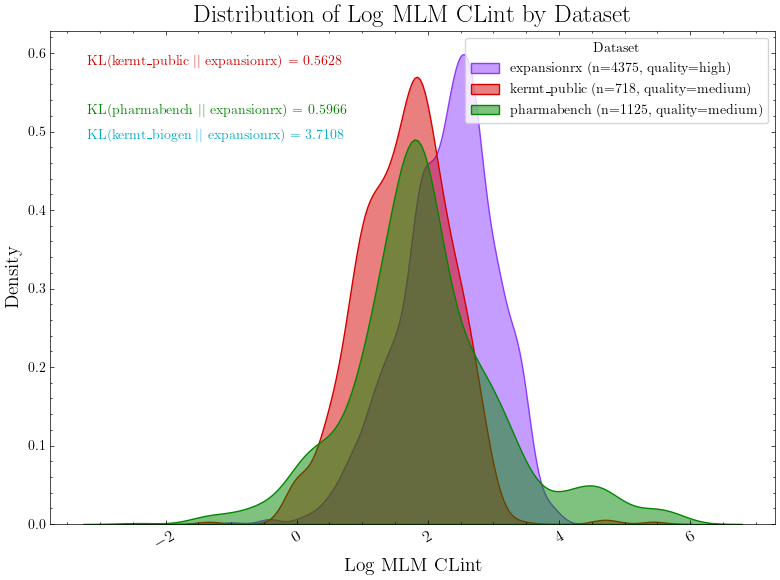

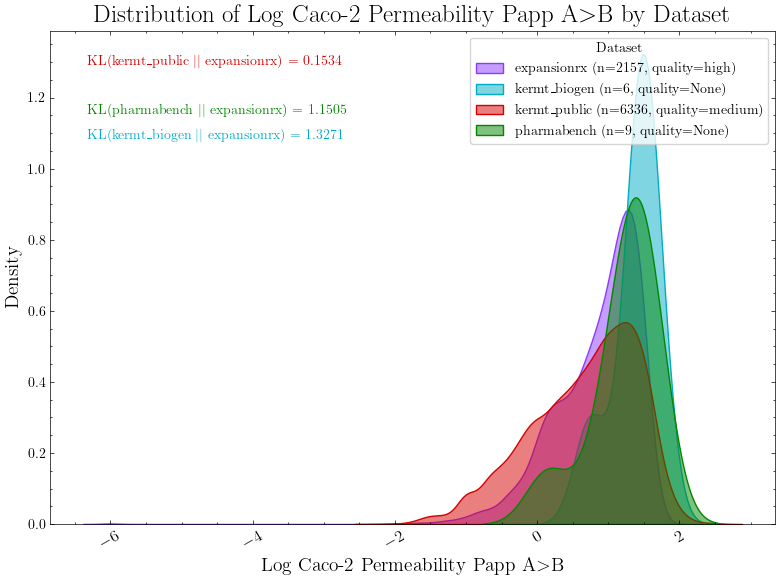

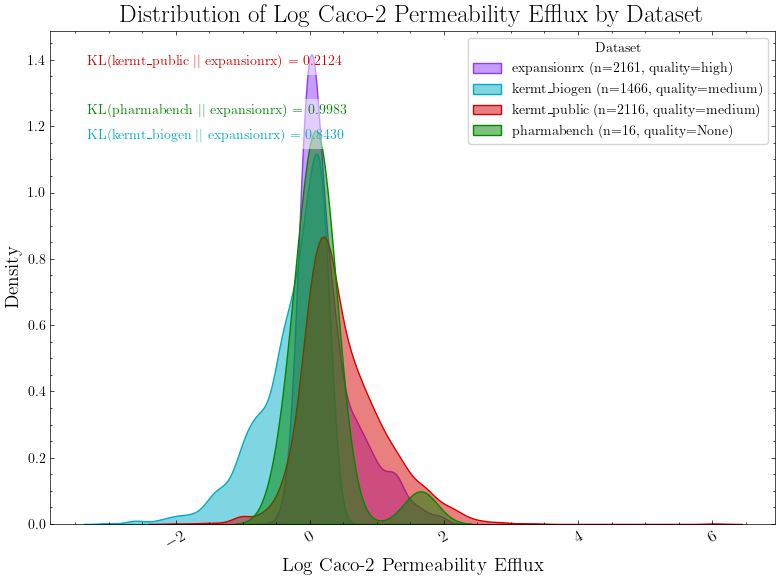

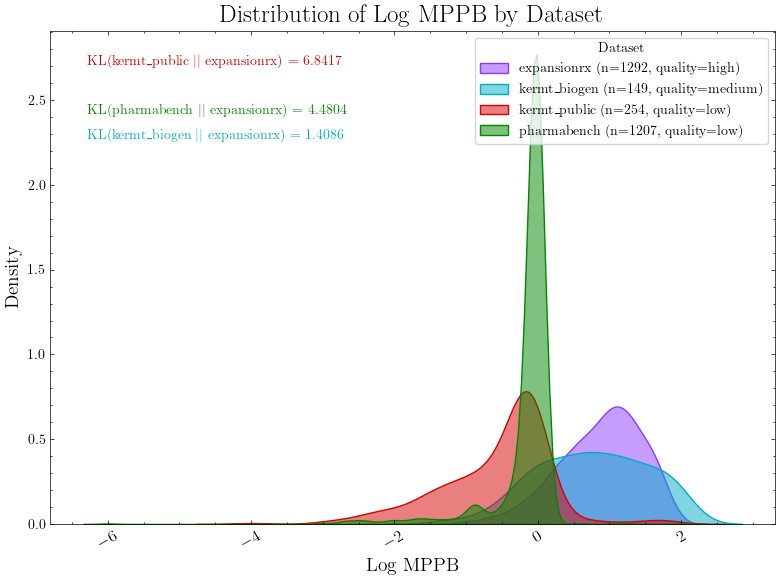

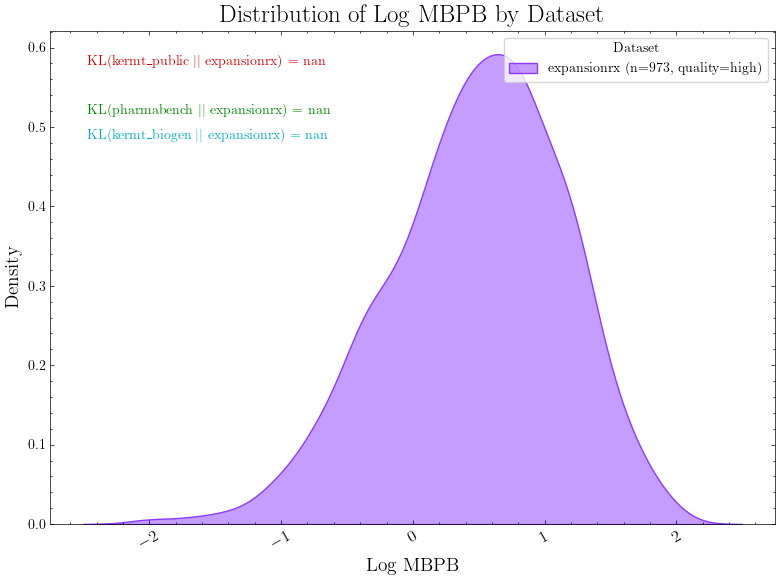

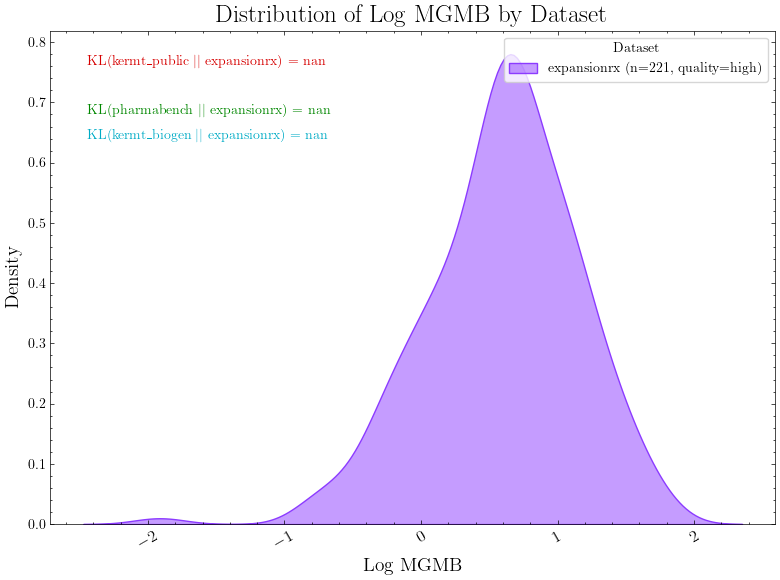

In [52]:
# plot the distribution of targets colored by dataset
target_cols = [col for col in df_out.columns if col != "SMILES" and col != "Dataset"]

colormap = cc.glasbey  # categorical colormap
dataset_to_color = {name: colormap[i] for i, name in enumerate(df_out["Dataset"].unique())}

reference_dataset = "expansionrx"

for target_col in target_cols:
    if not pd.api.types.is_numeric_dtype(df_out[target_col]):
        continue
    fig, ax = plt.subplots(figsize=(8, 6))
    logger.info(f"Plotting distribution for target column '{target_col}'")
    for dataset_name, group in df_out.groupby("Dataset"):
        sns.kdeplot(
            group[target_col].dropna(),
            ax=ax,
            label=dataset_name,
            fill=True,
            alpha=0.5,
            color=dataset_to_color[dataset_name],
        )
    ax.set_xlabel(target_col.replace(">", "$>$"), fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_title(f"Distribution of {target_col.replace('>', '$>$')} by Dataset", fontsize=18)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)

    # add KL divergence to reference dataset
    for dataset_name, group in df_out.groupby("Dataset"):
        if dataset_name == reference_dataset:
            continue
        # compute KL divergence
        data_ref = df_out[df_out["Dataset"] == reference_dataset][target_col].dropna()
        data_comp = group[target_col].dropna()
        # create histograms
        hist_ref, bin_edges = np.histogram(data_ref, bins=50, density=True)
        hist_comp, _ = np.histogram(data_comp, bins=bin_edges, density=True)
        # add small value to avoid zero entries
        hist_ref += 1e-10
        hist_comp += 1e-10
        kl_div = stats.entropy(hist_comp, hist_ref)
        ax.text(
            0.05,
            0.95 - 0.05 * list(df_out["Dataset"].unique()).index(dataset_name),
            f"KL({dataset_name} $||$ {reference_dataset}) = {kl_div:.4f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            color=dataset_to_color[dataset_name],
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
        )

    # for each dataset add number of samples to legend
    ax.legend(title="Dataset")
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        n_samples = df_out[df_out["Dataset"] == label][target_col].dropna().shape[0]
        quality = quality_table[quality_table["Dataset"] == label][target_col.replace("Log ", "Log ")].values[0]
        new_label = f"{label} (n={n_samples}, quality={quality})"
        new_labels.append(new_label)
    ax.legend(handles, new_labels, title="Dataset", loc="upper right", fontsize=10, frameon=True)

    fig.tight_layout()

    fname_out = (
        output_dir
        / f"combined_{target_col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_to_')}_distribution.png"
    )
    fig.savefig(
        fname_out,
        dpi=300,
    )
    logger.debug(f"Saved distribution plot at {fname_out}")

Computing molecular properties:   0%|          | 0/119796 [00:00<?, ?molecule/s]

2025-11-28 10:23:24,393 - __main__ - INFO - Plotting distribution for molecular property 'MW'
2025-11-28 10:23:25,285 - __main__ - INFO - Plotting distribution for molecular property 'TPSA'
2025-11-28 10:23:26,021 - __main__ - INFO - Plotting distribution for molecular property 'HBA'
2025-11-28 10:23:26,729 - __main__ - INFO - Plotting distribution for molecular property 'HBD'
2025-11-28 10:23:27,434 - __main__ - INFO - Plotting distribution for molecular property 'RotBonds'
2025-11-28 10:23:28,127 - __main__ - INFO - Plotting distribution for molecular property 'LogP'
2025-11-28 10:23:28,826 - __main__ - INFO - Plotting distribution for molecular property 'NumHeavyAtoms'
2025-11-28 10:23:29,535 - __main__ - INFO - Plotting distribution for molecular property 'NumRings'


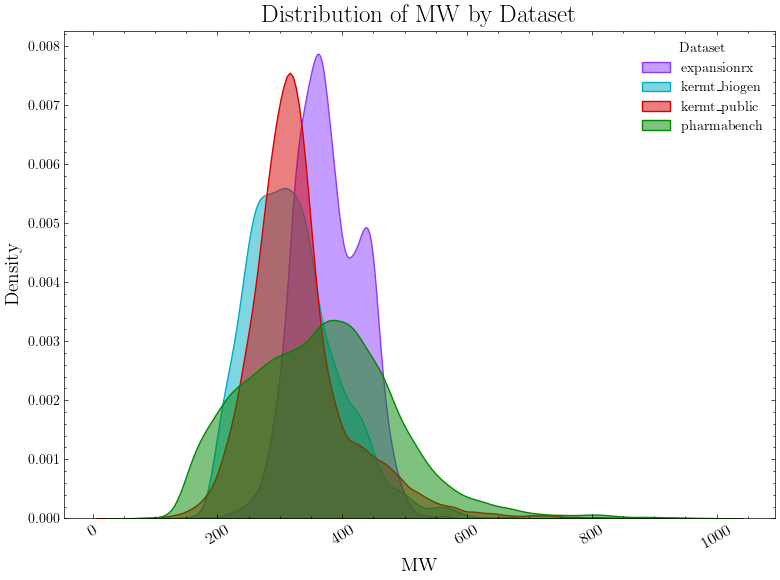

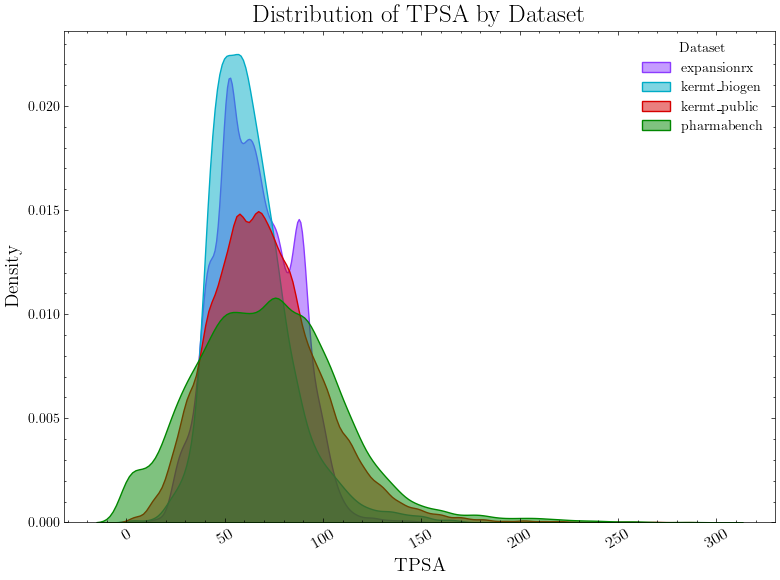

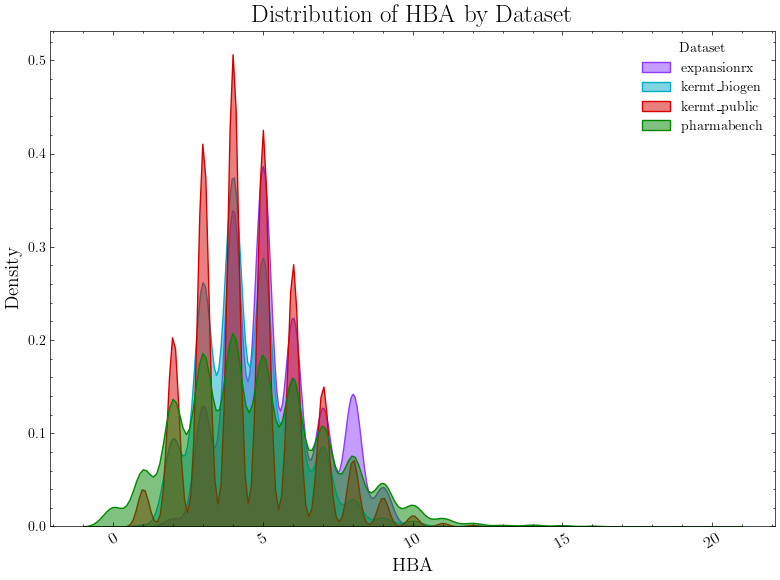

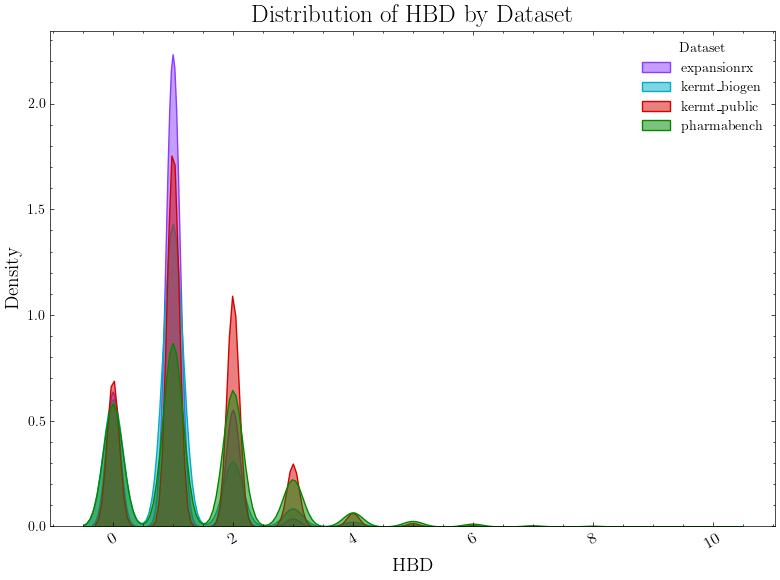

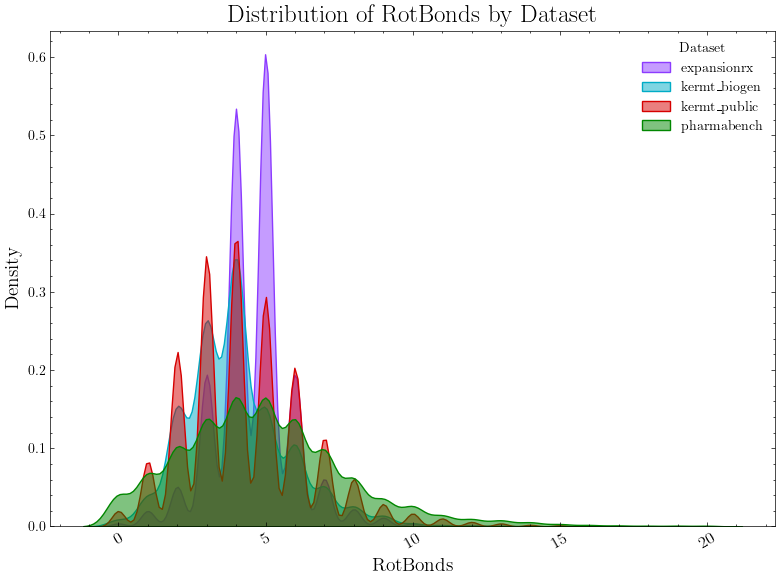

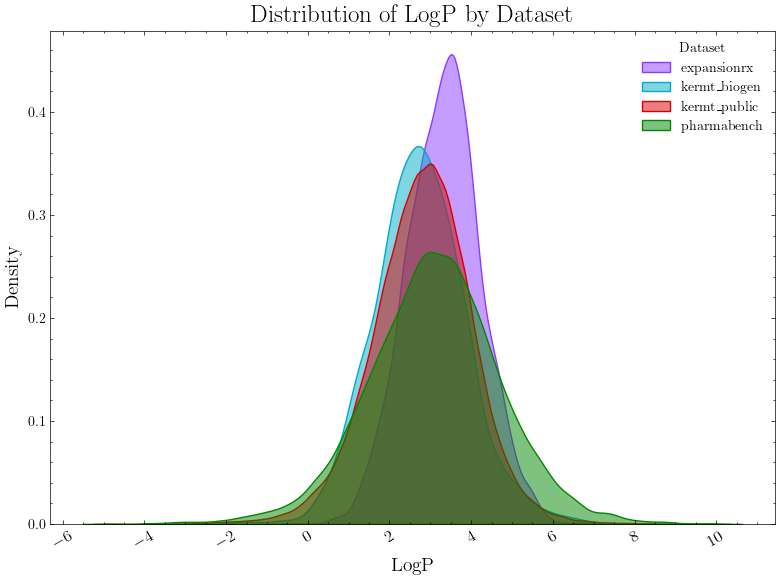

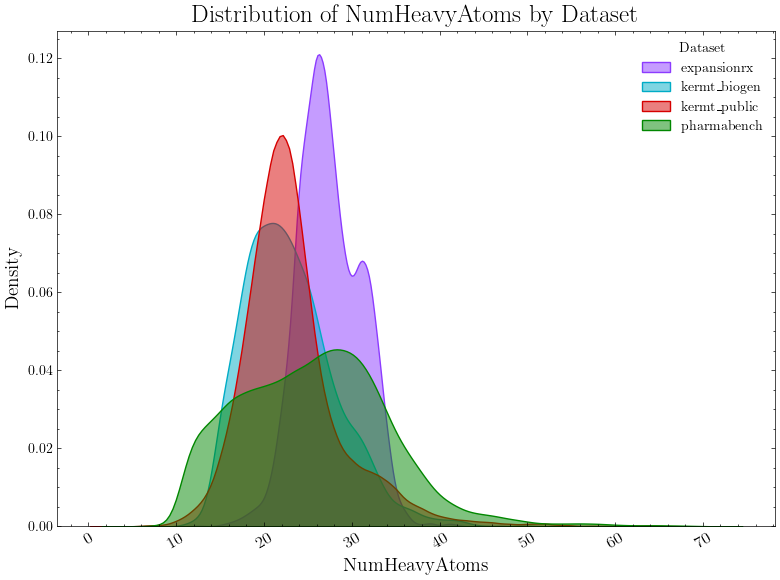

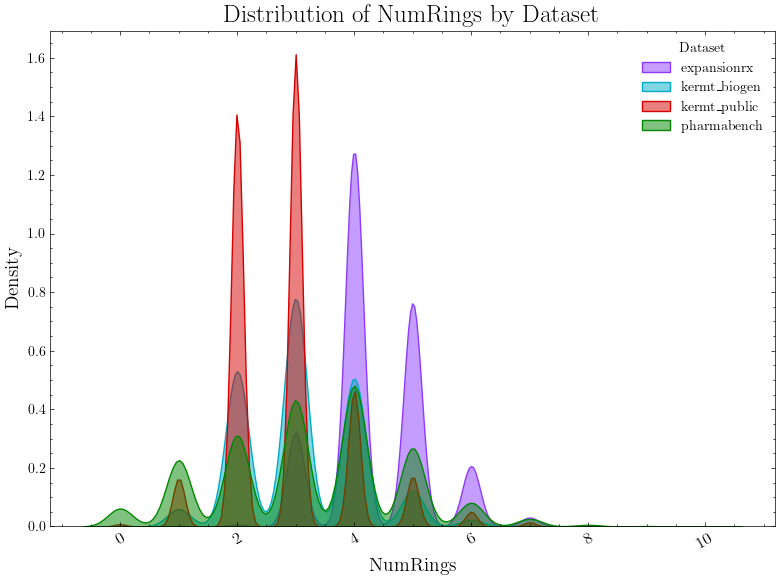

In [53]:
# plot distribution of molecular properties colored by dataset
df_props = compute_molecular_properties(df_out["SMILES"])
df_props["Dataset"] = df_out["Dataset"]
for prop_col in df_props.columns:
    if prop_col == "SMILES" or prop_col == "Dataset":
        continue
    fig, ax = plt.subplots(figsize=(8, 6))
    logger.info(f"Plotting distribution for molecular property '{prop_col}'")
    for dataset_name, group in df_props.groupby("Dataset"):
        sns.kdeplot(
            group[prop_col].dropna(),
            ax=ax,
            label=dataset_name,
            fill=True,
            alpha=0.5,
            color=dataset_to_color[dataset_name],
        )
    ax.set_xlabel(prop_col, fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_title(f"Distribution of {prop_col} by Dataset", fontsize=18)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.legend(title="Dataset")
    fig.tight_layout()

    fig.savefig(
        output_dir / f"combined_{prop_col.replace(' ', '_').replace('(', '').replace(')', '')}_distribution.png",
        bbox_inches="tight",
        dpi=300,
    )

In [54]:
# calculate tanimoto similarity between reference and other datasets
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
df_out["fingerprint"] = df_out["SMILES"].progress_apply(lambda smi: fpgen.GetFingerprint(Chem.MolFromSmiles(smi)))

  0%|          | 0/119796 [00:00<?, ?it/s]

2025-11-28 10:23:47,417 - __main__ - INFO - Calculating Tanimoto similarities for dataset 'kermt_biogen' against reference 'expansionrx'


Calculating Tanimoto for kermt_biogen:   0%|          | 0/3212 [00:00<?, ?it/s]

2025-11-28 10:23:49,234 - __main__ - INFO - Calculating Tanimoto similarities for dataset 'kermt_public' against reference 'expansionrx'


Calculating Tanimoto for kermt_public:   0%|          | 0/89594 [00:00<?, ?it/s]

2025-11-28 10:24:38,245 - __main__ - INFO - Calculating Tanimoto similarities for dataset 'pharmabench' against reference 'expansionrx'


Calculating Tanimoto for pharmabench:   0%|          | 0/21666 [00:00<?, ?it/s]

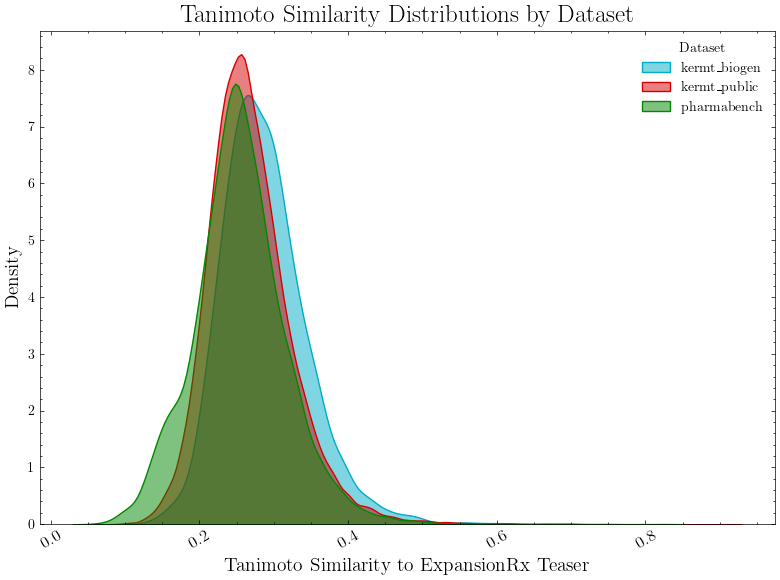

In [55]:
# plot the distribution of Tanimoto similarities to the reference set (ExpansionRx teaser)
df_reference = df_out[df_out["Dataset"] == "expansionrx"]


fig, ax = plt.subplots(figsize=(8, 6))
for dataset_name, group in df_out.groupby("Dataset"):
    if dataset_name == "expansionrx":
        continue
    logger.info(f"Calculating Tanimoto similarities for dataset '{dataset_name}' against reference 'expansionrx'")
    tanimoto_sims = []
    for fp in tqdm(group["fingerprint"], desc=f"Calculating Tanimoto for {dataset_name}"):
        sims = DataStructs.BulkTanimotoSimilarity(fp, df_reference["fingerprint"].tolist())
        max_sim = max(sims) if sims else 0.0
        tanimoto_sims.append(max_sim)
    group["Tanimoto to expansionrx"] = tanimoto_sims

    sns.kdeplot(
        group["Tanimoto to expansionrx"],
        ax=ax,
        label=dataset_name,
        fill=True,
        alpha=0.5,
        color=dataset_to_color[dataset_name],
    )
ax.set_xlabel("Tanimoto Similarity to ExpansionRx Teaser", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("Tanimoto Similarity Distributions by Dataset", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)
ax.legend(title="Dataset")
fig.tight_layout()
fig.savefig(
    output_dir / f"combined_tanimoto_similarity_distribution.png",
    dpi=600,
)

2025-11-28 10:24:51,201 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'kermt_biogen' -> 'expansionrx'


Tanimoto kermt_biogen->expansionrx:   0%|          | 0/3212 [00:00<?, ?it/s]

2025-11-28 10:24:52,890 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'expansionrx' -> 'kermt_public'


Tanimoto expansionrx->kermt_public:   0%|          | 0/5324 [00:00<?, ?it/s]

2025-11-28 10:25:57,664 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'expansionrx' -> 'pharmabench'


Tanimoto expansionrx->pharmabench:   0%|          | 0/5324 [00:00<?, ?it/s]

2025-11-28 10:26:09,343 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'kermt_biogen' -> 'kermt_public'


Tanimoto kermt_biogen->kermt_public:   0%|          | 0/3212 [00:00<?, ?it/s]

2025-11-28 10:26:48,615 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'kermt_biogen' -> 'pharmabench'


Tanimoto kermt_biogen->pharmabench:   0%|          | 0/3212 [00:00<?, ?it/s]

2025-11-28 10:26:55,661 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'pharmabench' -> 'kermt_public'


Tanimoto pharmabench->kermt_public:   0%|          | 0/21666 [00:00<?, ?it/s]

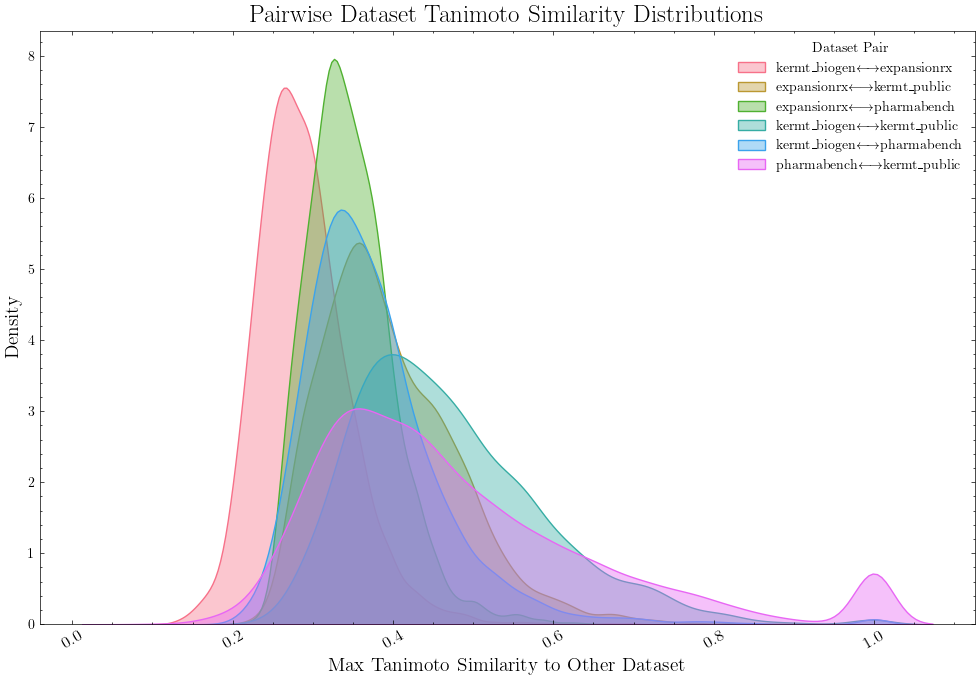

In [56]:
# plot the distribution of Tanimoto similarities between all dataset pairs
from itertools import combinations

# precompute fingerprint lists for each dataset
dataset_fps = {name: group["fingerprint"].tolist() for name, group in df_out.groupby("Dataset")}
dataset_pairs = list(combinations(dataset_fps.keys(), 2))
pair_palette = sns.color_palette("husl", n_colors=len(dataset_pairs))

fig, ax = plt.subplots(figsize=(10, 7))
for color, (ds_a, ds_b) in zip(pair_palette, dataset_pairs):
    # compute from the smaller source dataset to reduce total comparisons
    if len(dataset_fps[ds_a]) <= len(dataset_fps[ds_b]):
        source, target = ds_a, ds_b
    else:
        source, target = ds_b, ds_a
    target_fps = dataset_fps[target]
    tanimoto_sims = []
    logger.info("Calculating Tanimoto similarities for dataset pair '%s' -> '%s'" % (source, target))
    for fp in tqdm(dataset_fps[source], desc=f"Tanimoto {source}->{target}"):
        sims = DataStructs.BulkTanimotoSimilarity(fp, target_fps) if target_fps else []
        tanimoto_sims.append(max(sims) if sims else 0.0)
    pair_label = f"{source}" + r"$\longleftrightarrow$" + f"{target}"
    sns.kdeplot(
        tanimoto_sims,
        ax=ax,
        label=pair_label,
        fill=True,
        alpha=0.4,
        color=color,
    )
ax.set_xlabel("Max Tanimoto Similarity to Other Dataset", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("Pairwise Dataset Tanimoto Similarity Distributions", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)
ax.legend(title="Dataset Pair")
fig.tight_layout()
fig.savefig(output_dir / "pairwise_tanimoto_similarity_distribution.png", dpi=600)

In [57]:
# dataset split
test_percent = 0.15

# sort by dataset, then by Molecule Name, then by SMILES
df_dataset = df_out.sort_values(by=["Dataset", "Molecule Name", "SMILES"], ascending=[True, True, True])

# remove last 10% of expansionrx entries for test set
df_expansionrx = df_dataset[df_dataset["Dataset"] == "expansionrx"].copy()
n_expansionrx = len(df_expansionrx)
n_test = int(n_expansionrx * test_percent)
df_test = df_expansionrx.tail(n_test).copy()
df_train_val = df_dataset.drop(df_test.index).reset_index(drop=True)
df_train_val_expansionrx = df_train_val[df_train_val["Dataset"] == "expansionrx"]

# do not include fingerprint column in output
df_train_val_out = df_train_val.drop(columns=["fingerprint"])
df_test_out = df_test.drop(columns=["fingerprint"])

logger.info(f"Final train/val dataframe shape: {df_train_val_out.shape}")
logger.debug(f"Final train/val dataframe columns: {df_train_val_out.columns.tolist()}")
logger.info(f"Final test dataframe shape: {df_test_out.shape}")
logger.debug(f"Final test dataframe columns: {df_test_out.columns.tolist()}")

df_train_val_out.to_csv(output_dir / "cleaned_combined_admet_train_val.csv", index=False)
df_test_out.to_csv(output_dir / "cleaned_combined_admet_test.csv", index=False)


2025-11-28 10:31:25,504 - __main__ - INFO - Final train/val dataframe shape: (118998, 13)
2025-11-28 10:31:25,505 - __main__ - DEBUG - Final train/val dataframe columns: ['SMILES', 'Dataset', 'Quality', 'Molecule Name', 'LogD', 'Log KSOL', 'Log HLM CLint', 'Log MLM CLint', 'Log Caco-2 Permeability Papp A>B', 'Log Caco-2 Permeability Efflux', 'Log MPPB', 'Log MBPB', 'Log MGMB']
2025-11-28 10:31:25,505 - __main__ - INFO - Final test dataframe shape: (798, 13)
2025-11-28 10:31:25,505 - __main__ - DEBUG - Final test dataframe columns: ['SMILES', 'Dataset', 'Quality', 'Molecule Name', 'LogD', 'Log KSOL', 'Log HLM CLint', 'Log MLM CLint', 'Log Caco-2 Permeability Papp A>B', 'Log Caco-2 Permeability Efflux', 'Log MPPB', 'Log MBPB', 'Log MGMB']


2025-11-28 10:31:25,891 - __main__ - INFO - Column 'LogD': Train/Val non-NaN entries: 4242, Test non-NaN entries: 797
2025-11-28 10:31:25,892 - __main__ - INFO - Column 'Log KSOL': Train/Val non-NaN entries: 4335, Test non-NaN entries: 794
2025-11-28 10:31:25,892 - __main__ - INFO - Column 'Log HLM CLint': Train/Val non-NaN entries: 3560, Test non-NaN entries: 35
2025-11-28 10:31:25,893 - __main__ - INFO - Column 'Log MLM CLint': Train/Val non-NaN entries: 3831, Test non-NaN entries: 544
2025-11-28 10:31:25,893 - __main__ - INFO - Column 'Log Caco-2 Permeability Papp A>B': Train/Val non-NaN entries: 1986, Test non-NaN entries: 171
2025-11-28 10:31:25,893 - __main__ - INFO - Column 'Log Caco-2 Permeability Efflux': Train/Val non-NaN entries: 1990, Test non-NaN entries: 171
2025-11-28 10:31:25,894 - __main__ - INFO - Column 'Log MPPB': Train/Val non-NaN entries: 1139, Test non-NaN entries: 153
2025-11-28 10:31:25,894 - __main__ - INFO - Column 'Log MBPB': Train/Val non-NaN entries: 821, 

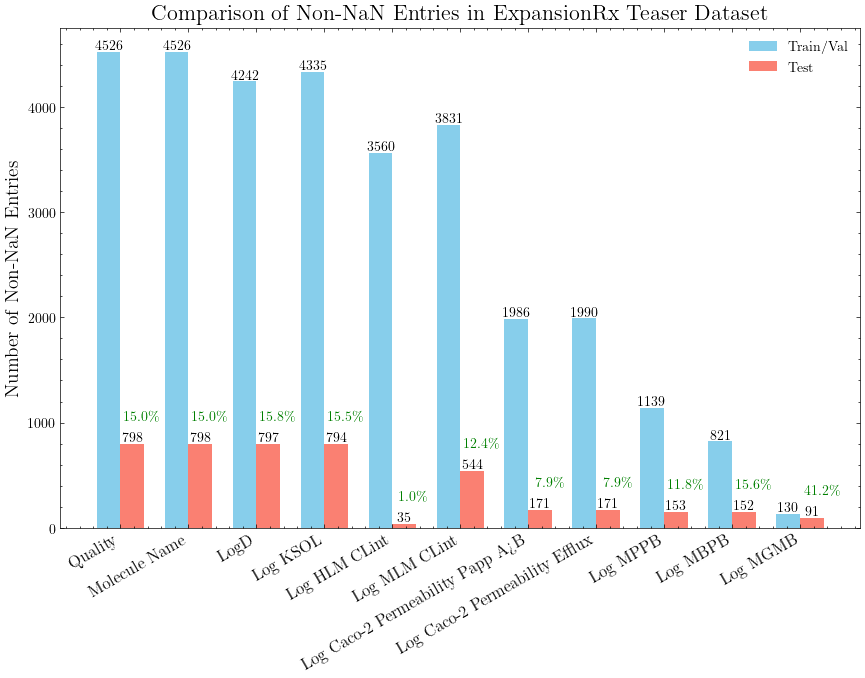

In [58]:
# comare the number of non-nan entries per column in expansionrx between train/val and test
for col in df_train_val_expansionrx.columns:
    if col in ["SMILES", "Dataset", "Molecule Name", "Quality"]:
        continue
    n_train_val = df_train_val_expansionrx[col].notna().sum()
    n_test = df_test[col].notna().sum()
    logger.info(f"Column '{col}': Train/Val non-NaN entries: {n_train_val}, Test non-NaN entries: {n_test}")

fig = plt.figure(figsize=(8, 5))
axes = fig.add_axes([0, 0, 1, 1])
x = np.arange(len(target_cols))
width = 0.35
train_val_counts = [df_train_val_expansionrx[col].notna().sum() for col in target_cols]
test_counts = [df_test[col].notna().sum() for col in target_cols]
axes.bar(x - width / 2, train_val_counts, width, label="Train/Val", color="skyblue")
axes.bar(x + width / 2, test_counts, width, label="Test", color="salmon")
axes.set_ylabel("Number of Non-NaN Entries", fontsize=14)
axes.set_title("Comparison of Non-NaN Entries in ExpansionRx Teaser Dataset", fontsize=16)
axes.set_xticks(x)
axes.set_xticklabels(target_cols, rotation=30, ha="right", fontsize=12)
axes.legend()

# add number labels on top of bars
for i in range(len(x)):
    axes.text(
        x[i] - width / 2, train_val_counts[i] + 1, str(train_val_counts[i]), ha="center", va="bottom", fontsize=10
    )
    axes.text(x[i] + width / 2, test_counts[i] + 1, str(test_counts[i]), ha="center", va="bottom", fontsize=10)

# add percentage of data in test set
for i in range(len(x)):
    if train_val_counts[i] + test_counts[i] > 0:
        percent_test = (test_counts[i] / (train_val_counts[i] + test_counts[i])) * 100
        axes.text(
            x[i] + width / 1.1,
            test_counts[i] + 200,
            f"{percent_test:.1f}\%",
            ha="center",
            va="bottom",
            fontsize=10,
            color="green",
        )
fig.tight_layout()
fig.savefig(
    output_dir / "expansionrx_train_val_test_non_nan_comparison.png",
    dpi=600,
)

In [59]:
endpoints = [col for col in df_out.columns if col not in ["SMILES", "Dataset", "Molecule Name", "Quality", "fingerprint"]]
endpoints

['LogD',
 'Log KSOL',
 'Log HLM CLint',
 'Log MLM CLint',
 'Log Caco-2 Permeability Papp A>B',
 'Log Caco-2 Permeability Efflux',
 'Log MPPB',
 'Log MBPB',
 'Log MGMB']

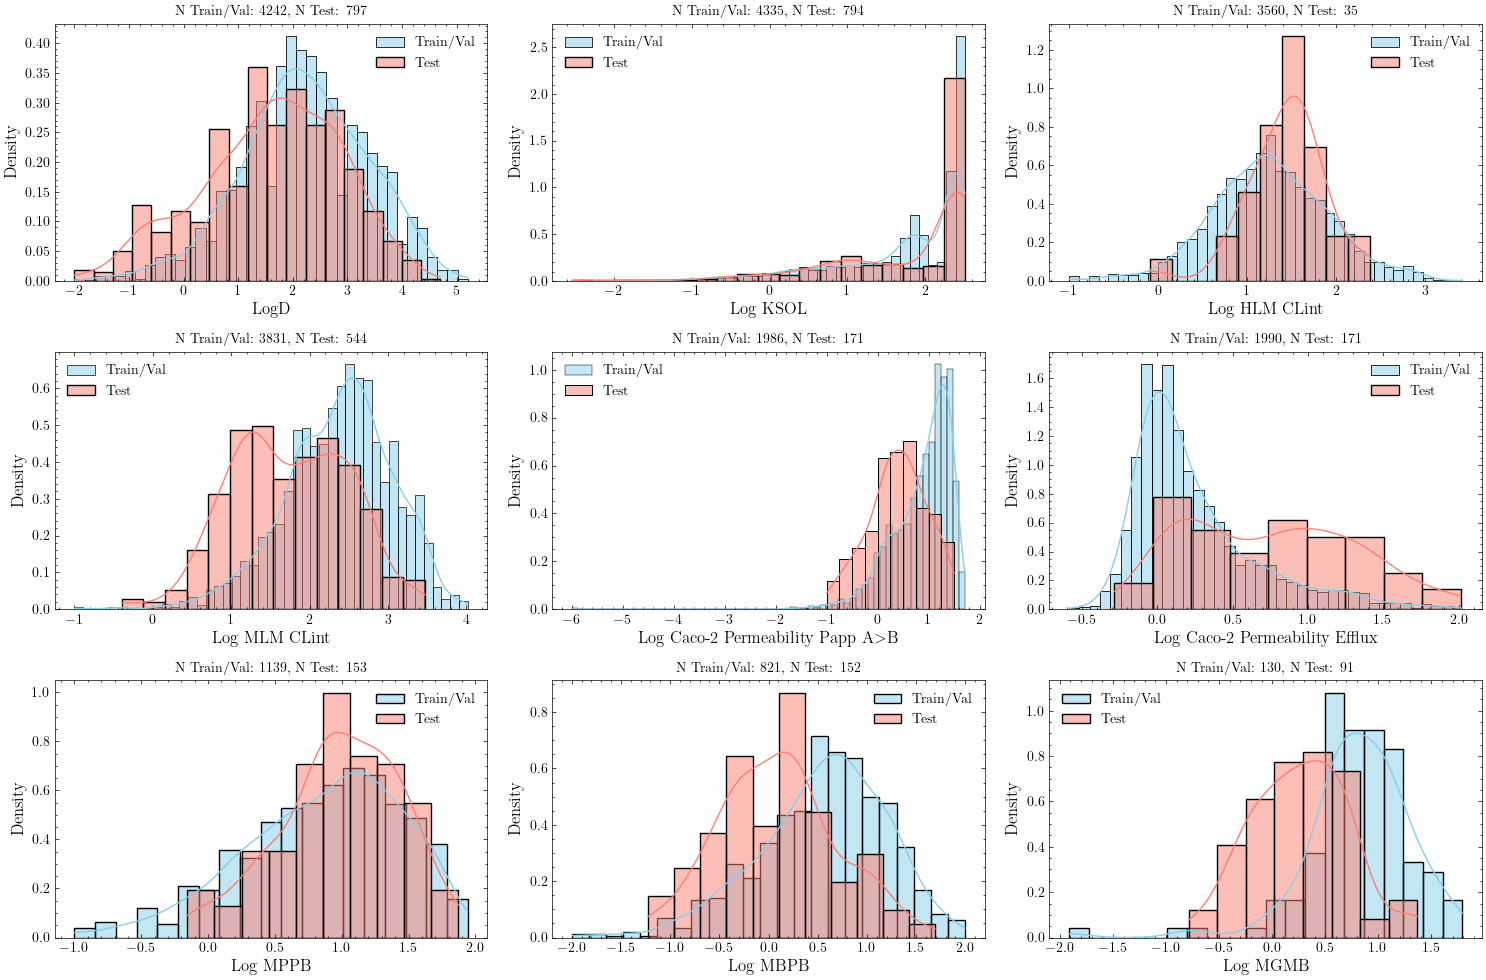

In [60]:
# plot distribution of targets in expansionrx between train/val and test
fig = plt.figure(figsize=(15, 10))
n_cols = 3
n_rows = int(np.ceil(len(endpoints) / n_cols))
for i, col in enumerate(endpoints):
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    
    sns.histplot(
        df_train_val_expansionrx[col].dropna(),
        ax=ax,
        label="Train/Val",
        color="skyblue",
        stat="density",
        kde=True,
    )
    sns.histplot(
        df_test[col].dropna(),
        ax=ax,
        label="Test",
        color="salmon",
        stat="density",
        kde=True,
    )
    ax.set_xlabel(col.replace(">", "$>$"), fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.legend()
    # add N numbers of samples
    n_train_val = df_train_val_expansionrx[col].notna().sum()
    n_test = df_test[col].notna().sum()
    ax.set_title(f"N Train/Val: {n_train_val}, N Test: {n_test}", fontsize=10)

fig.tight_layout()
fig.savefig(
    output_dir / "expansionrx_train_val_test_target_distributions.png",
    dpi=600,
)